# Assignments

The following assignments will test your knowledge in unsupervised learning. Note that this data is already nontrivial and some tasks can prove difficult. However, the point of the assignment is to practice and experiment with the techniques you learned. Therefore, do not get discouraged if you do not get the results you expect with one single method. Instead, try a few different approaches and see if you can spot any common patterns in the results. It is not the destination, but the journey that matters here :)

*Note: Only the conclusions, data and code presented in this notebook will be considered for grading. If there are other files that support your discussion, make sure they are clearly linked in this notebook.*

## Tools

Tools and concepts that might have not been discussed previously, but could be useful for these assignments:

- [Molecular Descriptors and Fingerprints](./01_examples_descriptors.ipynb)
- [Depicting Molecules in Jupyter Notebooks](./01_examples_depictions.ipynb)
- [Feature Scaling](https://scikit-learn.org/stable/modules/preprocessing.html)
- [Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- [Getting Clusters out of Hierarchical Clustering](https://stackoverflow.com/questions/44428512/get-a-list-of-clusters-formed-from-dendrogram-in-python)
- [pChEMBL Values](https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/chembl-data-questions#what-is-pchembl)

Feel free to also use resources online and scientific literature. Also pay attention to the various columns in the data sets. Some of them might be useful for your analysis and point you to the relevant literature. Making yourself familiar with the data itself can then help you better understand the results of your analysis.

# 1. Visualizing Chemical Space

In this assignment, you will use your previous knowledge about molecular descriptors and unsupervised learning to show maps of chemical space. The data set you will be working with is saved in the `molecules.csv` file. It provides only the structures of molecules as SMILES strings. These molecules can be clustered in multiple ways. Select the best set of descriptors and a clustering method that in your opinion captures the relationships between the molecules in the data set in the most meaningful way. Note that this assignment does not have a single correct answer. Therefore, do not be afraid to explore and present multiple distinct solutions.

In the discussion of your results, focus mainly on answering the following questions and include code and data to support your answers:

- How many distinct groups of compounds do you think there are in the data set and why?
- Was the dimensionality reduction method you chose able to group structurally similar compounds together? Look at the structures in a few clearly seperated clusters and discuss your findings. Can you find any potential outliers?
- What do you think are the main advantages and disadvantages of the dimensionality reduction method you chose?
- Do you obtain similar results with multiple dimensionality reduction methods? Try to compare at least two and also vary their parameters.
- Using PCA, is there a difference in between using fingerprints and descriptors as features? Do you obtain different results if you use some form of feature selection before PCA? How does scaling the features affect the result?

---

## Dataset & Featurization (Context)

- **Input**: `molecules.csv` with 287 SMILES; 0 missing, 76 duplicates. Post RDKit standardization (largest fragment, uncharge, tautomer canonicalization) and sanity filters → **209 unique molecules**. SMILES length: min 12, median 45, p90 = 69, max 644. 

- **Fingerprints**: ECFP4 (Morgan, radius=2, 2048-bit), binary.

- **Descriptors** (11 curated): MolWt, MolLogP, TPSA, HBD, HBA, RotB, FracCSP3, RingCount, QED, HeavyAtoms, FormalCharge. Scaled for PCA; correlation-filtered variant (ρ>0.9) yields 8 features. 

---

## 1) How many distinct groups are there, and why?

Two levels of granularity emerge:

### A. Coarse (global split): ≈ 2 groups

- **PCA on ECFP4** (2D) consistently gives k=2 with silhouette ≈ 0.802 (all PCA component counts; visualization in 2D). This indicates a dominating chemotype division captured by the top PCs. 

### B. Fine (family level): ≈ 8–14 subgroups

- **UMAP on ECFP4** (Jaccard), best composite configuration (n_neighbors=5, min_dist=0.01, n_components=30) yields:
  - **KMeans on full UMAP**: k=14, silhouette ≈ 0.810.
  - **HDBSCAN on full UMAP**: 8 clusters, ~12.4% noise.

  This reflects stable chemotype families and outlier surfacing. 

**Reference baselines**:
- **Butina** (Tanimoto distance) at cutoff=0.3 (~sim ≥0.7) fragments the set into 149 clusters (108 singletons), illustrating that very tight structural similarity produces many small groups.

---

## 2) Did the DR method group structurally similar compounds? Any outliers?

**Yes.**

- **UMAP(ECFP4) + HDBSCAN** clusters show recurring ring systems and substituent patterns within clusters (medoid grids). Examine the cluster medoids (first 3–4 clusters shown) and compare core frameworks and side-chains; local FP neighborhoods are preserved, and families are visually coherent. 

- **Outliers** (HDBSCAN label −1): a non-trivial fraction (~12.4% in the best full-dimensional run) are flagged as noise; these often include very large / atypically functionalized molecules (consistent with the long-tail in SMILES length, up to 644 characters). See the noise grids for examples. 

---

## 3) Advantages & disadvantages of the chosen DR method (UMAP on ECFP4, Jaccard)

### Advantages (empirically observed):

- **Clusterable embeddings**: KMeans silhouette up to ~0.810 with k≈14 on full UMAP; HDBSCAN finds 8 clusters with moderate noise—clearer family structure than PCA or t-SNE under tested settings. 

- **Locality preservation for binary FPs**: UMAP with Jaccard matches the semantics of ECFP similarity (presence/absence of bits). Trustworthiness is competitive (≈0.72 at best composite). 

- **Hyperparameter controllability**: n_neighbors and min_dist tune resolution: small n_neighbors + low min_dist sharpen clusters; larger n_neighbors improve trustworthiness (e.g., up to ~0.760 at n_neighbors=50, min_dist=0.3) at the cost of compactness. 

### Disadvantages (and mitigations):

- **Stochasticity / sensitivity**: Requires fixed seeds and small sweeps (as done) to stabilize results. 

- **Global distances not isometric**: Excellent for neighborhoods, less so for large-scale metric interpretation; complementary descriptor-PCA helps with interpretability (size/polarity axes). 

---

## 4) Do multiple DR methods agree? (Method comparison + param sweeps)

Side-by-side summary (from the best settings):

| Method | KMeans silhouette (best) | Optimal k | HDBSCAN clusters | HDBSCAN noise | Notes |
|--------|--------------------------|-----------|------------------|---------------|-------|
| **PCA** (ECFP4, 2D) | 0.8017 | 2 | 2 | 13.9% | Var explained (2 PCs): 10.4%. Captures a strong global split.|
| **UMAP** (ECFP4, best composite) | 0.8102 | 14 | 8 | 12.4% | n_neighbors=5, min_dist=0.01, n_components=30, trustworthiness ≈ 0.720. Family-level structure. |
| **t-SNE** (ECFP4, best) | 0.4466 | 2 | 2 | 50.7% | Best perplexity 30; fragmented neighborhoods for clustering here. |

**Agreement**: All methods reveal a strong global split (~2 groups); UMAP exposes richer substructure (≈8–14). A diagnostic shows correlation (ρ ≈ 0.888) between 2D vs full-dimensional KMeans silhouettes across UMAP configs, i.e., relative quality rankings are stable across projection depth.

### Parameter trends (UMAP):

- Max silhouette occurs at small n_neighbors & min_dist (tighter clusters).
- Max trustworthiness occurs at larger n_neighbors / min_dist (smoother geometry), but silhouettes drop (e.g., trust ≈ 0.760 at n_neighbors=50, min_dist=0.3, with silhouettes ≈ 0.37–0.45). Choose based on downstream use (visual separation vs. structure preservation).

---

## 5) PCA: fingerprints vs descriptors; feature selection; scaling

Key findings from the PCA experiments:

| PCA Input | PC1+PC2 variance | Best 2D KMeans silhouette | Best k | Notes |
|-----------|------------------|---------------------------|--------|-------|
| **Descriptors** (scaled) | ~69.7% | ~0.555 | 3 | Balanced, interpretable axes (size/polarity/flexibility).|
| **Descriptors** (unscaled) | ~100% (PC1≈97%) | ~0.823 | 2 | PC1 dominates due to magnitude (e.g., MolWt/HeavyAtoms) → artificially clean split.|
| **Descriptors** (corr-filtered + scaled) | ~62.9% | ~0.537 | 3 | Removes redundancy (11→8) with similar patterning.|
| **Fingerprints** (binary) | ~10.4% | ~0.802 | 2 | Low variance captured by 2 PCs yet strong global split appears; PCA is not ideal for multi-family resolution on FPs.|

### Scaling matters (quantitatively):

**Unscaled descriptors**: PC1 = 0.970 of variance; **scaled descriptors**: PC1 = 0.521 (Δ ≈ 0.449). Scaling prevents domination by high-magnitude features (e.g., MolWt), yielding more balanced and interpretable principal axes. Descriptor ranges confirm normalization (mean≈0, std≈1 after scaling). 

### Feature selection (correlation filtering):

At ρ>0.9, removing 3 highly collinear descriptors (keeping 8) slightly reduces PC1+PC2 variance (69.7% → 62.9%) and slightly lowers 2D silhouette (0.555 → 0.537), suggesting a stability/interpretability trade-off without changing the overall picture.

### Fingerprints vs descriptors under PCA:

- **Descriptors** → interpretable axes and sensible k≈3 grouping (scaled).
- **Fingerprints** → PCA explains little variance in 2D yet shows one dominant chemotype split (k=2); for richer families, UMAP on FPs is superior.

---

## Task 1. Configuration

In [39]:
# Reproducibility and paths
import os, math, warnings, random
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import umap
import hdbscan

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

DATA_PATH = "molecules.csv"

SMILES_COL_CANDIDATES = ["Ligand SMILES"]

# Visualization defaults
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams["figure.figsize"] = (6, 5)
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100


import warnings
warnings.filterwarnings("ignore")

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')


## 2. Load data & initial QC (string-level; RDKit-free)

We first inspect the CSV and pick the SMILES column by common names. Robust cheminformatics QC happens in the next section with RDKit.

In [2]:
from pathlib import Path

df_raw = pd.read_csv(DATA_PATH)
print(f"Loaded shape: {df_raw.shape}")
print("Columns:", list(df_raw.columns))

# choose smiles column
smiles_col = None
for c in SMILES_COL_CANDIDATES:
    if c in df_raw.columns:
        smiles_col = c
        break
if smiles_col is None:
    # fallback to first column
    smiles_col = df_raw.columns[0]
print("Chosen SMILES column:", smiles_col)

df_raw = df_raw.rename(columns={smiles_col: "SMILES"})
df_raw["SMILES"] = df_raw["SMILES"].astype(str).str.strip()
print("Missing SMILES:", df_raw["SMILES"].isna().sum())
print("Duplicate SMILES strings:", df_raw["SMILES"].duplicated().sum())

# Basic string-only diagnostics
lens = df_raw["SMILES"].str.len()
print("SMILES length stats:", lens.describe()[["min","25%","50%","mean","75%","max"]])

has_dot = df_raw["SMILES"].str.contains(r"\.", regex=True)
has_chiral = df_raw["SMILES"].str.contains("@", regex=False)
has_isotope = df_raw["SMILES"].str.contains(r"\[\d+", regex=True)

string_qc = pd.DataFrame({
    "has_dot_fragment": has_dot,
    "has_chirality": has_chiral,
    "has_isotope": has_isotope,
})
string_qc.value_counts().to_frame("count")


Loaded shape: (287, 1)
Columns: ['Ligand SMILES']
Chosen SMILES column: Ligand SMILES
Missing SMILES: 0
Duplicate SMILES strings: 76
SMILES length stats: min      12.000000
25%      32.000000
50%      45.000000
mean     53.059233
75%      58.000000
max     644.000000
Name: SMILES, dtype: float64


count
has_dot_fragment has_chirality has_isotope       
False            False         False          194
                 True          False           91
                 False         True             1
                 True          True             1

## 3. Molecular standardization (RDKit MolStandardize)

We apply a robust cleaning pipeline before featurization:
1. **Parse SMILES → Mol** (drop failures)
2. **Largest fragment** (remove salts/solvents)
3. **Uncharge** (normalize formal charges where appropriate)
4. **Tautomer canonicalization**
5. **Canonical SMILES & InChIKey**

In [40]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Descriptors, Crippen, Lipinski, QED
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs


def to_mol(smiles: str):
    m = Chem.MolFromSmiles(smiles)
    return m

_lfc = rdMolStandardize.LargestFragmentChooser()
_uncharger = rdMolStandardize.Uncharger()
_te = rdMolStandardize.TautomerEnumerator()

def standardize_mol(m: Chem.Mol):
    if m is None:
        return None
    try:
        m = _lfc.choose(m)
        m = _uncharger.uncharge(m)
        m = _te.Canonicalize(m)
        Chem.SanitizeMol(m)
        return m
    except Exception as e:
        return None

def canon_smiles(m: Chem.Mol):
    return Chem.MolToSmiles(m, isomericSmiles=True, canonical=True) if m is not None else None

def inchi_key(m: Chem.Mol):
    try:
        return Chem.MolToInchiKey(m)
    except Exception:
        return None

# Parse -> standardize
mols = df_raw["SMILES"].apply(to_mol).apply(standardize_mol)

# Remove Nones
valid_mask = mols.notna()
df = df_raw.loc[valid_mask].copy().reset_index(drop=True)
mols = mols[valid_mask].reset_index(drop=True)

df["can_smiles"] = mols.apply(canon_smiles)
df["inchi_key"] = mols.apply(inchi_key)

# Deduplicate by canonical SMILES
before = len(df)
dfu = df.drop_duplicates(subset=["can_smiles"]).reset_index(drop=True)
mols_u = [m for m in mols.loc[dfu.index]]  # aligned with dfu
after = len(dfu)
print(f"Deduplicated by canonical SMILES: {before} -> {after} molecules (removed {before-after}).")

# Basic chemical sanity filters (optional; keep lenient)
def is_reasonable(m):
    try:
        return (m.GetNumAtoms() >= 3) and (m.GetNumAtoms() <= 150)
    except Exception:
        return False

keep_mask = [is_reasonable(m) for m in mols_u]
dfu = dfu.loc[keep_mask].reset_index(drop=True)
mols_u = [m for (m, k) in zip(mols_u, keep_mask) if k]
print(f"Post sanity-filter count: {len(mols_u)}")


Deduplicated by canonical SMILES: 287 -> 211 molecules (removed 76).
Post sanity-filter count: 209


## 4. Feature engineering

We compute **ECFP4** (radius=2, 2048 bits) and a curated set of **physicochemical descriptors**.

- Fingerprints are **binary**; we **do not scale** them.
- Descriptors are **scaled** (`StandardScaler`) when used for PCA/clustering.

In [4]:
from sklearn.preprocessing import StandardScaler

FP_NBITS = 2048
FP_RADIUS = 2

def morgan_fp_bitvect(m: Chem.Mol, nBits=FP_NBITS, radius=FP_RADIUS):
    fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nBits)
    return fp_gen.GetFingerprint(m)

def fp_to_numpy(fp) -> np.ndarray:
    arr = np.zeros((FP_NBITS,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Fingerprints
fps = [morgan_fp_bitvect(m) for m in mols_u]
X_fp = np.vstack([fp_to_numpy(fp) for fp in fps])
print("X_fp shape:", X_fp.shape)

# Descriptors (curated, interpretable)
def compute_descriptors(m):
    return {
        "MolWt": Descriptors.MolWt(m),
        "MolLogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "HBD": rdMolDescriptors.CalcNumHBD(m),
        "HBA": rdMolDescriptors.CalcNumHBA(m),
        "RotB": rdMolDescriptors.CalcNumRotatableBonds(m),
        "FracCSP3": rdMolDescriptors.CalcFractionCSP3(m),
        "RingCount": rdMolDescriptors.CalcNumRings(m),
        "QED": QED.qed(m),
        "HeavyAtoms": m.GetNumHeavyAtoms(),
        "FormalCharge": Chem.GetFormalCharge(m),
    }

desc_rows = [compute_descriptors(m) for m in mols_u]
df_desc = pd.DataFrame(desc_rows)
print("Descriptors head:")
display(df_desc.head())

# Preprocess descriptors
#  - remove near-zero variance
#  - scale (Z-score)
nzv_mask = df_desc.std(axis=0) > 1e-8
df_desc_nzv = df_desc.loc[:, nzv_mask]
scaler = StandardScaler()
X_desc_scaled = scaler.fit_transform(df_desc_nzv.values)
desc_cols = list(df_desc_nzv.columns)
print("Descriptor matrix shape:", X_desc_scaled.shape)


X_fp shape: (209, 2048)
Descriptors head:


,MolWt,MolLogP,TPSA,HBD,HBA,RotB,FracCSP3,RingCount,QED,HeavyAtoms,FormalCharge
0,277.411,4.1686,3.24,0,1,3,0.300000,3,0.813678,21,0
1,266.388,3.5328,15.27,1,2,4,0.333333,3,0.851637,20,0
2,233.311,2.0853,38.33,1,3,3,0.500000,2,0.812340,17,0
3,205.301,2.5996,20.31,0,2,5,0.461538,1,0.688599,15,0
4,471.561,4.2226,102.48,2,6,6,0.296296,5,0.524184,35,0


Descriptor matrix shape: (209, 11)


## 5. Baseline structural clustering: Butina (Tanimoto distance)

Butina is a fast clusterer on **pairwise Tanimoto distance** and serves as a baseline. We sweep distance cutoffs to see how granularity changes.

> Note: This requires an \(O(n^2)\) distance list. For large `n`, we cap at `MAX_BUTINA_N` or sample.

In [5]:
from rdkit.ML.Cluster import Butina

MAX_BUTINA_N = 5000

def tanimoto_distance_condensed(fps):
    dists = []
    for i in range(1, len(fps)):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1.0 - s for s in sims])
    return dists

def run_butina(fps, cutoff=0.3):
    N = len(fps)
    if N > MAX_BUTINA_N:
        raise RuntimeError(f"Butina is capped at {MAX_BUTINA_N} molecules; you have {N}. Consider sampling.")
    dists = tanimoto_distance_condensed(fps)
    clusters = Butina.ClusterData(dists, N, cutoff, isDistData=True, reordering=True)
    # clusters is a tuple of clusters, each as a tuple of member indices
    labels = -np.ones(N, dtype=int)
    for cid, members in enumerate(clusters):
        for idx in members:
            labels[idx] = cid
    return labels, clusters

butina_cutoffs = [0.2, 0.3, 0.4, 0.5, 0.6]  # distance = 1 - similarity
butina_results = {}
for c in butina_cutoffs:
    labels, clusters = run_butina(fps, cutoff=c)
    n_clust = len(clusters)
    n_singletons = sum(1 for cl in clusters if len(cl)==1)
    butina_results[c] = dict(labels=labels, clusters=clusters, n_clusters=n_clust, n_singletons=n_singletons)

pd.DataFrame([{"cutoff": c, **{ "n_clusters": v["n_clusters"], "n_singletons": v["n_singletons"]}} for c,v in butina_results.items()])


,cutoff,n_clusters,n_singletons
0,0.2,154,112
1,0.3,149,108
2,0.4,143,103
3,0.5,135,96
4,0.6,123,82


## 6. Fingerprint space → DR (PCA, UMAP) + clustering (KMeans, HDBSCAN)

We evaluate **PCA** and **UMAP** on binary ECFP4 vectors. For clustering, we run **KMeans** (with `K` chosen by silhouette) and **HDBSCAN** (density-based, labels `-1` = noise).

We also compute **Trustworthiness** to assess local structure preservation.

### 6.1 Helper Functions

In [6]:
def kmeans_sweep(Z, k_range=range(2, 16)):

    best = None
    rows = []
    
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
        labels = km.fit_predict(Z)
        
        try:
            sil = silhouette_score(Z, labels, metric="euclidean")
        except Exception:
            sil = np.nan
        
        db = davies_bouldin_score(Z, labels)
        rows.append({"k": k, "silhouette": sil, "davies_bouldin": db})
        
        if best is None or (not np.isnan(sil) and sil > best[0]):
            best = (sil, k, labels, km)
    
    return pd.DataFrame(rows), best

### 6.2 Vis Functions

In [7]:
def scatter2d_enhanced(Z, labels=None, title="", ax=None, 
                       show_legend=True, alpha=0.7, s=15, highlight_noise=True):

    if ax is None:
        ax = plt.gca()
    
    if labels is None:
        ax.scatter(Z[:,0], Z[:,1], s=s, alpha=alpha, c='steelblue', edgecolors='none')
    else:
        unique_labels = np.unique(labels)
        
        # Select appropriate colormap
        if len(unique_labels) <= 10:
            colors = plt.cm.tab10(np.linspace(0, 1, 10))
        elif len(unique_labels) <= 20:
            colors = plt.cm.tab20(np.linspace(0, 1, 20))
        else:
            colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
        
        # Handle noise points separately (HDBSCAN uses -1 for noise)
        if highlight_noise and -1 in unique_labels:
            mask_noise = labels == -1
            ax.scatter(Z[mask_noise, 0], Z[mask_noise, 1], 
                      s=s, alpha=alpha*0.3, c='lightgray', 
                      edgecolors='none', label='Noise')
            unique_labels = unique_labels[unique_labels != -1]
        
        # Plot each cluster
        for idx, lab in enumerate(unique_labels):
            mask = labels == lab
            ax.scatter(Z[mask, 0], Z[mask, 1], 
                      s=s, alpha=alpha, c=[colors[idx % len(colors)]], 
                      edgecolors='none', label=f'Cluster {lab}')
        
        if show_legend and len(unique_labels) <= 15:
            ax.legend(loc="best", fontsize=8, frameon=True, 
                     framealpha=0.8, ncol=2 if len(unique_labels) > 8 else 1)
    
    ax.set_xlabel("Dimension 1", fontsize=10)
    ax.set_ylabel("Dimension 2", fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_axisbelow(True)

### 6.3 PCA Parameter Sweep

In [8]:
# Define PCA component options
pca_components_fp = [2, 10, 50, 100]
pca_results_fp = {}

# Perform PCA with different numbers of components
for n in pca_components_fp:
    n_eff = min(n, X_fp.shape[1])  # Prevent exceeding feature dimensions
    pca = PCA(n_components=n_eff, random_state=RANDOM_STATE)
    Z = pca.fit_transform(X_fp)
    evr = pca.explained_variance_ratio_.sum()
    
    pca_results_fp[n_eff] = {
        "Z": Z, 
        "pca": pca, 
        "explained_variance_total": evr
    }
    print(f"  PCA with {n_eff} components: {evr:.2%} variance explained")

  PCA with 2 components: 10.40% variance explained
  PCA with 10 components: 30.09% variance explained
  PCA with 50 components: 69.87% variance explained
  PCA with 100 components: 91.08% variance explained


### 6.4 PCA + K-Means Evaluation (2D for Visualization)

In [9]:
pca_kmeans_fp = {}

for n, res in pca_results_fp.items():
    # Cluster on first 2 PCs for fair visualization comparison
    dfk, best = kmeans_sweep(res["Z"][:, :2], k_range=range(2, 16))
    pca_kmeans_fp[n] = {"sweep": dfk, "best": best}
    
    if best:
        print(f"  PCA-{n}: Best k={best[1]}, Silhouette={best[0]:.4f}")

  PCA-2: Best k=2, Silhouette=0.8017
  PCA-10: Best k=2, Silhouette=0.8017
  PCA-50: Best k=2, Silhouette=0.8017
  PCA-100: Best k=2, Silhouette=0.8017


In [10]:
for n, res in pca_results_fp.items():
    Z_full = res["Z"]  # Full PCA embedding
    
    # KMeans on full dimensions
    dfk_full, best_full = kmeans_sweep(Z_full, k_range=range(2, 16))
    res["kmeans_sweep_full"] = dfk_full
    res["kmeans_best_full"] = best_full
    
    # HDBSCAN on full dimensions
    hdb_full = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
    labels_hdb_full = hdb_full.fit_predict(Z_full)
    n_clusters_hdb = len(set(labels_hdb_full) - {-1})
    noise_frac_hdb = float(np.mean(labels_hdb_full == -1))
    
    res["hdbscan_labels_full"] = labels_hdb_full
    res["hdbscan_n_clusters_full"] = n_clusters_hdb
    res["hdbscan_noise_frac_full"] = noise_frac_hdb
    
    print(f"\nPCA-{n} (full {n} dimensions):")
    if best_full:
        print(f"  KMeans: k={best_full[1]}, Silhouette={best_full[0]:.4f}")
    print(f"  HDBSCAN: {n_clusters_hdb} clusters, Noise={noise_frac_hdb:.2%}")
    
    # Compare with 2D results
    best_2d = pca_kmeans_fp[n]["best"]
    if best_2d and best_full:
        improvement = best_full[0] - best_2d[0]
        print(f"  Improvement from 2D to {n}D: {improvement:+.4f}")


PCA-2 (full 2 dimensions):
  KMeans: k=2, Silhouette=0.8017
  HDBSCAN: 2 clusters, Noise=13.88%
  Improvement from 2D to 2D: +0.0000

PCA-10 (full 10 dimensions):
  KMeans: k=2, Silhouette=0.5923
  HDBSCAN: 2 clusters, Noise=44.02%
  Improvement from 2D to 10D: -0.2094

PCA-50 (full 50 dimensions):
  KMeans: k=2, Silhouette=0.3745
  HDBSCAN: 2 clusters, Noise=65.07%
  Improvement from 2D to 50D: -0.4273

PCA-100 (full 100 dimensions):
  KMeans: k=14, Silhouette=0.0998
  HDBSCAN: 2 clusters, Noise=80.38%
  Improvement from 2D to 100D: -0.7019


In [11]:
pca_comparison_rows = []

for n, res in pca_results_fp.items():
    best_2d = pca_kmeans_fp[n]["best"]
    best_full = res["kmeans_best_full"]
    
    pca_comparison_rows.append({
        "n_components": n,
        "variance_explained": f"{res['explained_variance_total']:.2%}",
        "kmeans_sil_2d": best_2d[0] if best_2d else np.nan,
        "kmeans_k_2d": best_2d[1] if best_2d else np.nan,
        "kmeans_sil_full": best_full[0] if best_full else np.nan,
        "kmeans_k_full": best_full[1] if best_full else np.nan,
        "silhouette_gain": (best_full[0] - best_2d[0]) if (best_2d and best_full) else np.nan,
        "hdbscan_clusters": res["hdbscan_n_clusters_full"],
        "hdbscan_noise": f"{res['hdbscan_noise_frac_full']:.2%}"
    })

df_pca_comparison = pd.DataFrame(pca_comparison_rows)
display(df_pca_comparison)

# Find best PCA configuration
best_pca_idx = df_pca_comparison["kmeans_sil_full"].idxmax()
best_pca = pca_results_fp[df_pca_comparison.loc[best_pca_idx, "n_components"]]

print(f"\nBest PCA configuration (by full-dimensional silhouette):")
print(f"  n_components: {df_pca_comparison.loc[best_pca_idx, 'n_components']}")
print(f"  Silhouette (full): {df_pca_comparison.loc[best_pca_idx, 'kmeans_sil_full']:.4f}")
print(f"  Variance explained: {df_pca_comparison.loc[best_pca_idx, 'variance_explained']}")

,n_components,variance_explained,kmeans_sil_2d,kmeans_k_2d,kmeans_sil_full,kmeans_k_full,silhouette_gain,hdbscan_clusters,hdbscan_noise
0,2,10.40%,0.801741,2,0.801741,2,0.000000,2,13.88%
1,10,30.09%,0.801742,2,0.592302,2,-0.209440,2,44.02%
2,50,69.87%,0.801742,2,0.374469,2,-0.427272,2,65.07%
3,100,91.08%,0.801741,2,0.099806,14,-0.701935,2,80.38%



Best PCA configuration (by full-dimensional silhouette):
  n_components: 2
  Silhouette (full): 0.8017
  Variance explained: 10.40%


### 6.5 UMAP Parameter Sweep

In [12]:
# Define UMAP parameter grid
umap_params = {
    "n_neighbors": [5, 15, 50],
    "min_dist": [0.01, 0.1, 0.3],
    "n_components": [2, 3, 5, 10, 20, 30, 50],
    "metric": ["jaccard"]  # Appropriate for binary fingerprints
}

total_configs = (len(umap_params["n_neighbors"]) * 
                 len(umap_params["min_dist"]) * 
                 len(umap_params["n_components"]) * 
                 len(umap_params["metric"]))

umap_results_fp = []
config_count = 0

for nn in umap_params["n_neighbors"]:
    for md in umap_params["min_dist"]:
        for nc in umap_params["n_components"]:
            for metric in umap_params["metric"]:
                config_count += 1
                
                # Train UMAP
                reducer = umap.UMAP(n_neighbors=nn, min_dist=md, 
                                   n_components=nc, metric=metric, 
                                   random_state=RANDOM_STATE)
                Z = reducer.fit_transform(X_fp)
                
                # Calculate trustworthiness (structure preservation)
                tw = trustworthiness(X_fp, Z, n_neighbors=10)
                
                # KMeans evaluation on first 2D (for initial comparison)
                if nc >= 2:
                    dfk, best = kmeans_sweep(Z[:, :2], k_range=range(2, 16))
                else:
                    dfk, best = (pd.DataFrame(), None)
                
                # HDBSCAN on 2D projection
                hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
                labels_h = hdb.fit_predict(Z[:, :2] if nc > 2 else Z)
                n_hdb = len(set(labels_h) - {-1})
                frac_noise = float(np.mean(labels_h == -1))
                
                umap_results_fp.append({
                    "params": {"n_neighbors": nn, "min_dist": md, 
                              "n_components": nc, "metric": metric},
                    "Z": Z,
                    "trustworthiness": tw,
                    "kmeans_sweep": dfk,
                    "kmeans_best": best,
                    "hdbscan_labels": labels_h,
                    "hdbscan_n_clusters": n_hdb,
                    "hdbscan_noise_frac": frac_noise,
                    "reducer": reducer,
                })


### 6.6 Re-evaluation of UMAP on Full Dims

In [13]:
for idx, r in enumerate(umap_results_fp):
    Z_full = r["Z"]
    
    # KMeans on full dimensions
    dfk_full, best_full = kmeans_sweep(Z_full, k_range=range(2, 16))
    r["kmeans_sweep_full"] = dfk_full
    r["kmeans_best_full"] = best_full
    
    # HDBSCAN on full dimensions
    hdb_full = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
    labels_hdb_full = hdb_full.fit_predict(Z_full)
    n_clusters_hdb = len(set(labels_hdb_full) - {-1})
    noise_frac_hdb = float(np.mean(labels_hdb_full == -1))
    
    r["hdbscan_labels_full"] = labels_hdb_full
    r["hdbscan_n_clusters_full"] = n_clusters_hdb
    r["hdbscan_noise_frac_full"] = noise_frac_hdb

### 6.7 Comparison Table

In [14]:
comparison_rows = []

for r in umap_results_fp:
    best_full = r["kmeans_best_full"]
    
    row = {
        # UMAP hyperparameters
        "n_neighbors": r["params"]["n_neighbors"],
        "min_dist": r["params"]["min_dist"],
        "n_components": r["params"]["n_components"],
        "metric": r["params"]["metric"],
        
        # Dimensionality reduction quality
        "trustworthiness": r["trustworthiness"],
        
        # KMeans on full dimensions
        "kmeans_silhouette_full": best_full[0] if best_full and not np.isnan(best_full[0]) else np.nan,
        "kmeans_optimal_k": best_full[1] if best_full else np.nan,
        "kmeans_davies_bouldin": r["kmeans_sweep_full"].loc[
            r["kmeans_sweep_full"]["k"] == best_full[1], "davies_bouldin"
        ].values[0] if best_full else np.nan,
        
        # HDBSCAN on full dimensions
        "hdbscan_n_clusters_full": r["hdbscan_n_clusters_full"],
        "hdbscan_noise_frac_full": r["hdbscan_noise_frac_full"],
        
        # Original 2D metrics for comparison
        "kmeans_silhouette_2d": r["kmeans_best"][0] if r["kmeans_best"] else np.nan,
        "hdbscan_noise_frac_2d": r["hdbscan_noise_frac"],
    }
    comparison_rows.append(row)

df_comparison = pd.DataFrame(comparison_rows)

df_comparison

,n_neighbors,min_dist,n_components,metric,trustworthiness,kmeans_silhouette_full,kmeans_optimal_k,kmeans_davies_bouldin,hdbscan_n_clusters_full,hdbscan_noise_frac_full,kmeans_silhouette_2d,hdbscan_noise_frac_2d
0,5,0.01,2,jaccard,0.725433,0.794062,12,0.213160,8,0.100478,0.794062,0.100478
1,5,0.01,3,jaccard,0.717320,0.766567,13,0.258560,8,0.047847,0.742548,0.081340
2,5,0.01,5,jaccard,0.711371,0.763997,12,0.246529,7,0.114833,0.765680,0.038278
3,5,0.01,10,jaccard,0.715631,0.782636,11,0.282475,8,0.157895,0.730660,0.095694
4,5,0.01,20,jaccard,0.703226,0.788680,11,0.272608,8,0.124402,0.704828,0.090909
...,...,...,...,...,...,...,...,...,...,...,...,...
58,50,0.30,5,jaccard,0.746968,0.381170,3,1.051507,2,0.009569,0.533195,0.296651
59,50,0.30,10,jaccard,0.755664,0.380849,3,1.044713,4,0.234450,0.479535,0.210526
60,50,0.30,20,jaccard,0.759853,0.376409,3,1.071406,5,0.263158,0.547190,0.253589
61,50,0.30,30,jaccard,0.755012,0.375953,3,1.094136,4,0.253589,0.505037,0.282297


### 6.8 Display Top Configs

In [15]:
top_silhouette = df_comparison.sort_values("kmeans_silhouette_full", ascending=False).head(10)
display(top_silhouette[[
    "n_neighbors", "min_dist", "n_components", "metric",
    "kmeans_silhouette_full", "kmeans_optimal_k", "trustworthiness"
]])

,n_neighbors,min_dist,n_components,metric,kmeans_silhouette_full,kmeans_optimal_k,trustworthiness
5,5,0.01,30,jaccard,0.810167,14,0.720191
0,5,0.01,2,jaccard,0.794062,12,0.725433
4,5,0.01,20,jaccard,0.788680,11,0.703226
3,5,0.01,10,jaccard,0.782636,11,0.715631
1,5,0.01,3,jaccard,0.766567,13,0.717320
6,5,0.01,50,jaccard,0.766378,15,0.707095
2,5,0.01,5,jaccard,0.763997,12,0.711371
12,5,0.10,30,jaccard,0.757948,14,0.699425
13,5,0.10,50,jaccard,0.749681,11,0.718415
11,5,0.10,20,jaccard,0.748646,11,0.722792


In [16]:
top_trust = df_comparison.sort_values("trustworthiness", ascending=False).head(10)
display(top_trust[[
    "n_neighbors", "min_dist", "n_components", "metric",
    "trustworthiness", "kmeans_silhouette_full", "kmeans_optimal_k"
]])

,n_neighbors,min_dist,n_components,metric,trustworthiness,kmeans_silhouette_full,kmeans_optimal_k
60,50,0.3,20,jaccard,0.759853,0.376409,3
39,15,0.3,20,jaccard,0.757000,0.453493,7
59,50,0.3,10,jaccard,0.755664,0.380849,3
61,50,0.3,30,jaccard,0.755012,0.375953,3
53,50,0.1,20,jaccard,0.753827,0.418692,3
62,50,0.3,50,jaccard,0.753661,0.382934,3
40,15,0.3,30,jaccard,0.750637,0.465462,9
52,50,0.1,10,jaccard,0.750276,0.436862,3
41,15,0.3,50,jaccard,0.749127,0.460884,7
32,15,0.1,20,jaccard,0.748874,0.548456,7


In [17]:
top_db = df_comparison.sort_values("kmeans_davies_bouldin", ascending=True).head(10)
display(top_db[[
    "n_neighbors", "min_dist", "n_components", "metric",
    "kmeans_davies_bouldin", "kmeans_silhouette_full", "trustworthiness"
]])

,n_neighbors,min_dist,n_components,metric,kmeans_davies_bouldin,kmeans_silhouette_full,trustworthiness
0,5,0.01,2,jaccard,0.213160,0.794062,0.725433
5,5,0.01,30,jaccard,0.228711,0.810167,0.720191
16,5,0.30,5,jaccard,0.230694,0.691985,0.736803
17,5,0.30,10,jaccard,0.240817,0.687889,0.724444
2,5,0.01,5,jaccard,0.246529,0.763997,0.711371
1,5,0.01,3,jaccard,0.258560,0.766567,0.717320
6,5,0.01,50,jaccard,0.259138,0.766378,0.707095
4,5,0.01,20,jaccard,0.272608,0.788680,0.703226
11,5,0.10,20,jaccard,0.278254,0.748646,0.722792
3,5,0.01,10,jaccard,0.282475,0.782636,0.715631


In [18]:
top_hdb = df_comparison.sort_values("hdbscan_noise_frac_full", ascending=True).head(10)
display(top_hdb[[
    "n_neighbors", "min_dist", "n_components", "metric",
    "hdbscan_noise_frac_full", "hdbscan_n_clusters_full", "kmeans_silhouette_full"
]])

,n_neighbors,min_dist,n_components,metric,hdbscan_noise_frac_full,hdbscan_n_clusters_full,kmeans_silhouette_full
29,15,0.10,3,jaccard,0.000000,5,0.540868
24,15,0.01,10,jaccard,0.004785,9,0.596504
31,15,0.10,10,jaccard,0.009569,8,0.538618
58,50,0.30,5,jaccard,0.009569,2,0.381170
21,15,0.01,2,jaccard,0.014354,9,0.571466
36,15,0.30,3,jaccard,0.014354,4,0.451796
26,15,0.01,30,jaccard,0.014354,9,0.588242
23,15,0.01,5,jaccard,0.019139,7,0.571273
27,15,0.01,50,jaccard,0.019139,8,0.606359
9,5,0.10,5,jaccard,0.023923,9,0.737660


### 6.9 Composite Scoring Strategy and Select Best Config

In [19]:
# Normalize metrics to 0-1 scale (higher is better)
df_comparison["score_silhouette"] = df_comparison["kmeans_silhouette_full"].fillna(-1)
df_comparison["score_silhouette"] = (
    (df_comparison["score_silhouette"] - df_comparison["score_silhouette"].min()) / 
    (df_comparison["score_silhouette"].max() - df_comparison["score_silhouette"].min())
)

df_comparison["score_trustworthiness"] = df_comparison["trustworthiness"]

# Davies-Bouldin: lower is better, so invert
df_comparison["score_db"] = 1 - (
    (df_comparison["kmeans_davies_bouldin"] - df_comparison["kmeans_davies_bouldin"].min()) / 
    (df_comparison["kmeans_davies_bouldin"].max() - df_comparison["kmeans_davies_bouldin"].min())
)

# HDBSCAN noise: lower is better, so invert
df_comparison["score_hdbscan"] = 1 - df_comparison["hdbscan_noise_frac_full"]

# Weighted composite score (adjust weights based on priorities)
df_comparison["composite_score"] = (
    0.35 * df_comparison["score_silhouette"] +      # Cluster quality
    0.30 * df_comparison["score_trustworthiness"] +  # Structure preservation
    0.20 * df_comparison["score_db"] +               # Cluster separation
    0.15 * df_comparison["score_hdbscan"]            # Density-based clustering
)

print("\nTOP 10 CONFIGURATIONS BY COMPOSITE SCORE")
print("-"*80)
top_composite = df_comparison.sort_values("composite_score", ascending=False).head(10)
display(top_composite[[
    "n_neighbors", "min_dist", "n_components", "metric",
    "kmeans_silhouette_full", "trustworthiness", "kmeans_davies_bouldin",
    "hdbscan_noise_frac_full", "composite_score"
]])


TOP 10 CONFIGURATIONS BY COMPOSITE SCORE
--------------------------------------------------------------------------------


,n_neighbors,min_dist,n_components,metric,kmeans_silhouette_full,trustworthiness,kmeans_davies_bouldin,hdbscan_noise_frac_full,composite_score
5,5,0.01,30,jaccard,0.810167,0.720191,0.228711,0.124402,0.893867
0,5,0.01,2,jaccard,0.794062,0.725433,0.213160,0.100478,0.889577
1,5,0.01,3,jaccard,0.766567,0.717320,0.258560,0.047847,0.862568
4,5,0.01,20,jaccard,0.788680,0.703226,0.272608,0.124402,0.861491
3,5,0.01,10,jaccard,0.782636,0.715631,0.282475,0.157895,0.853077
2,5,0.01,5,jaccard,0.763997,0.711371,0.246529,0.114833,0.851395
6,5,0.01,50,jaccard,0.766378,0.707095,0.259138,0.100478,0.851322
11,5,0.10,20,jaccard,0.748646,0.722792,0.278254,0.052632,0.844576
13,5,0.10,50,jaccard,0.749681,0.718415,0.298574,0.105263,0.831589
9,5,0.10,5,jaccard,0.737660,0.710594,0.304850,0.023923,0.830330


In [20]:
best_idx = df_comparison["composite_score"].idxmax()
best_umap = umap_results_fp[best_idx]

print(f"Parameters: {best_umap['params']}")
print(f"Trustworthiness: {best_umap['trustworthiness']:.4f}")
print(f"KMeans Silhouette (full): {best_umap['kmeans_best_full'][0]:.4f}")
print(f"KMeans Optimal K: {best_umap['kmeans_best_full'][1]}")
print(f"HDBSCAN Clusters (full): {best_umap['hdbscan_n_clusters_full']}")
print(f"HDBSCAN Noise Fraction (full): {best_umap['hdbscan_noise_frac_full']:.4f}")
print(f"Composite Score: {df_comparison.loc[best_idx, 'composite_score']:.4f}")

Parameters: {'n_neighbors': 5, 'min_dist': 0.01, 'n_components': 30, 'metric': 'jaccard'}
Trustworthiness: 0.7202
KMeans Silhouette (full): 0.8102
KMeans Optimal K: 14
HDBSCAN Clusters (full): 8
HDBSCAN Noise Fraction (full): 0.1244
Composite Score: 0.8939


### 6.10 2D v.s. Full Dimensional Comparison

In [21]:
# Calculate correlation between 2D and full-dimensional metrics
corr_silhouette = df_comparison[["kmeans_silhouette_2d", "kmeans_silhouette_full"]].corr().iloc[0, 1]
print(f"\nCorrelation (Silhouette 2D vs Full): {corr_silhouette:.4f}\n")

# Show cases where 2D and full-dimensional results differ significantly
df_comparison["silhouette_diff"] = (
    df_comparison["kmeans_silhouette_full"] - df_comparison["kmeans_silhouette_2d"]
)

print("Configurations with largest improvement from 2D to Full dimensions:")
print("-"*80)
display(df_comparison.nlargest(5, "silhouette_diff")[[
    "n_neighbors", "min_dist", "n_components", "metric",
    "kmeans_silhouette_2d", "kmeans_silhouette_full", "silhouette_diff"
]])


Correlation (Silhouette 2D vs Full): 0.8883

Configurations with largest improvement from 2D to Full dimensions:
--------------------------------------------------------------------------------


,n_neighbors,min_dist,n_components,metric,kmeans_silhouette_2d,kmeans_silhouette_full,silhouette_diff
9,5,0.10,5,jaccard,0.641775,0.737660,0.095886
4,5,0.01,20,jaccard,0.704828,0.788680,0.083852
3,5,0.01,10,jaccard,0.730660,0.782636,0.051976
1,5,0.01,3,jaccard,0.742548,0.766567,0.024019
20,5,0.30,50,jaccard,0.676335,0.696932,0.020597


### 6.11 t-SNE Parameter Sweep

In [22]:
perplexities = [5, 30, 50, 100]
tsne_results_fp = []

for perp in perplexities:
    print(f"  Computing t-SNE with perplexity = {perp}...")
    
    tsne = TSNE(n_components=2, perplexity=perp,
                random_state=RANDOM_STATE, metric='jaccard')
    Z_tsne = tsne.fit_transform(X_fp)
    
    # Evaluate with KMeans
    dfk, best = kmeans_sweep(Z_tsne, k_range=range(2, 16))
    
    # Evaluate with HDBSCAN
    hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
    labels_hdb = hdb.fit_predict(Z_tsne)
    n_clusters_hdb = len(set(labels_hdb) - {-1})
    noise_frac_hdb = float(np.mean(labels_hdb == -1))
    
    tsne_results_fp.append({
        "perplexity": perp,
        "Z": Z_tsne,
        "kmeans_best": best,
        "kmeans_sweep": dfk,
        "hdbscan_labels": labels_hdb,
        "hdbscan_n_clusters": n_clusters_hdb,
        "hdbscan_noise_frac": noise_frac_hdb
    })

# Find best t-SNE by silhouette score
best_tsne = max(tsne_results_fp, 
                key=lambda x: x["kmeans_best"][0] if x["kmeans_best"] else -1)
print(f"\nBest t-SNE perplexity: {best_tsne['perplexity']}")
print(f"Best silhouette score: {best_tsne['kmeans_best'][0]:.4f}\n")

  Computing t-SNE with perplexity = 5...
  Computing t-SNE with perplexity = 30...
  Computing t-SNE with perplexity = 50...
  Computing t-SNE with perplexity = 100...

Best t-SNE perplexity: 30
Best silhouette score: 0.4466



### 6.12 Visualizations

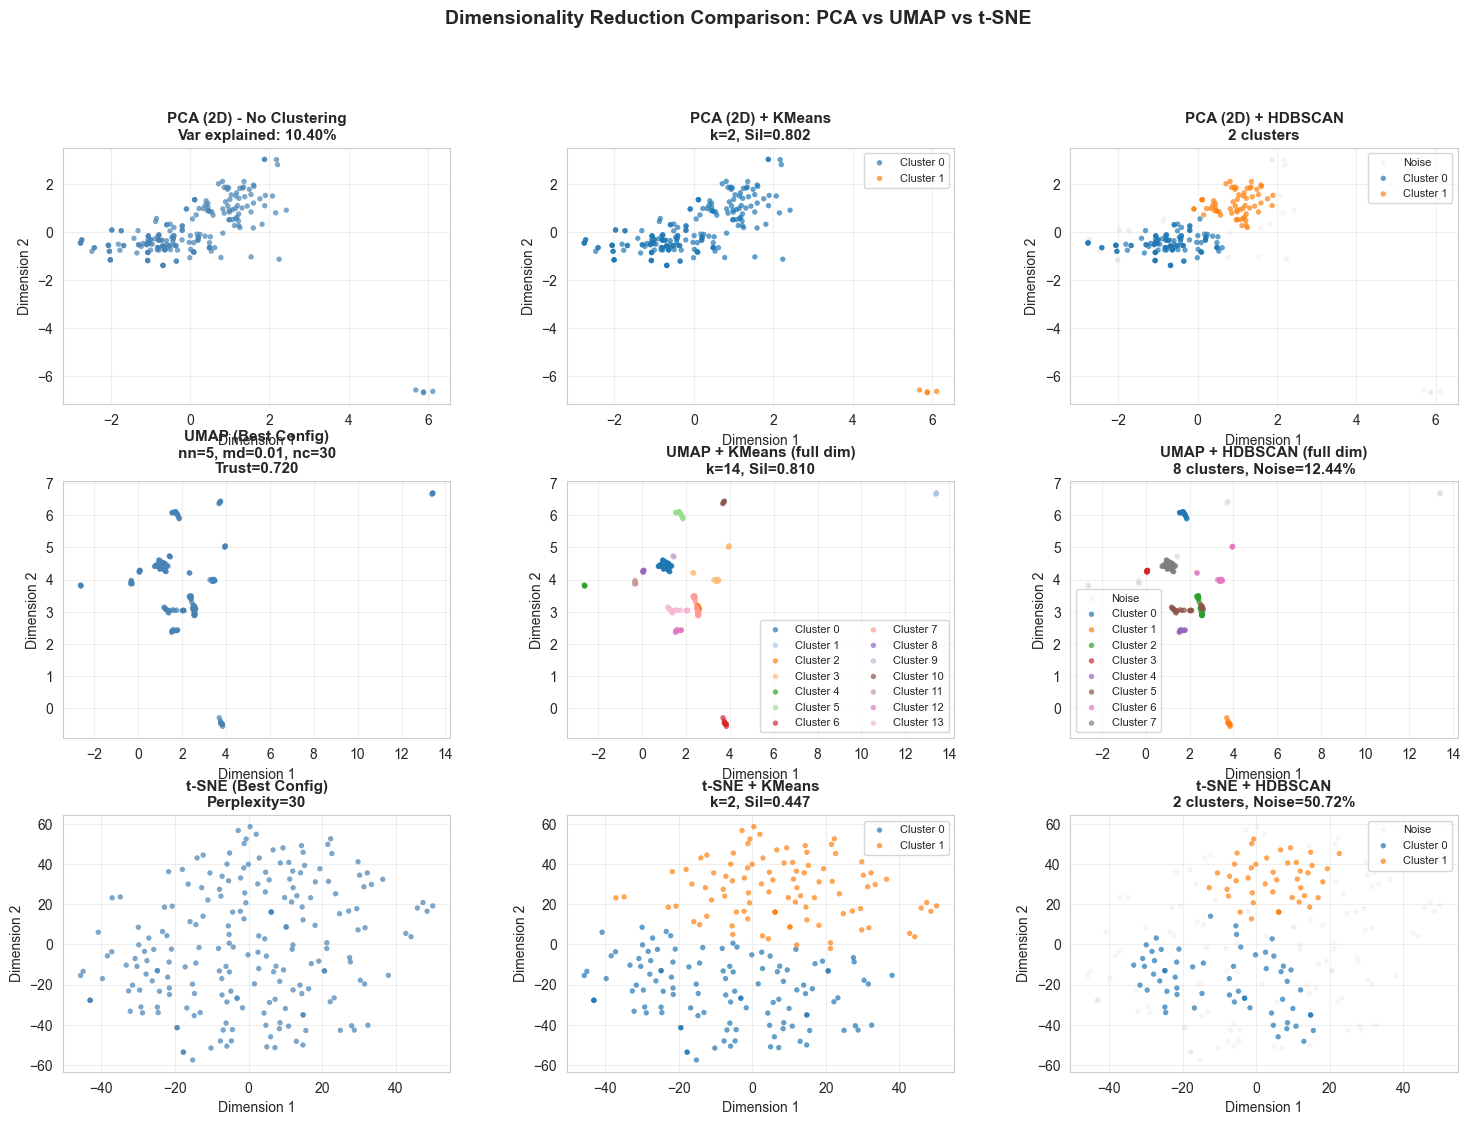

In [23]:
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# --- Row 1: PCA ---
Zp = pca_results_fp[2]["Z"]
kbest_pca = pca_kmeans_fp[2]["best"]
labels_k_pca = kbest_pca[2] if kbest_pca else None

# PCA - No clustering
ax1 = fig.add_subplot(gs[0, 0])
scatter2d_enhanced(
    Zp[:, :2], labels=None,
    title=f"PCA (2D) - No Clustering\nVar explained: {pca_results_fp[2]['explained_variance_total']:.2%}",
    ax=ax1
)

# PCA + KMeans
ax2 = fig.add_subplot(gs[0, 1])
scatter2d_enhanced(
    Zp[:, :2], labels=labels_k_pca,
    title=f"PCA (2D) + KMeans\nk={kbest_pca[1]}, Sil={kbest_pca[0]:.3f}",
    ax=ax2, highlight_noise=False
)

# PCA + HDBSCAN
hdb_pca = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
labels_hdb_pca = hdb_pca.fit_predict(Zp[:, :2])
n_clusters_pca = len(set(labels_hdb_pca) - {-1})

ax3 = fig.add_subplot(gs[0, 2])
scatter2d_enhanced(
    Zp[:, :2], labels=labels_hdb_pca,
    title=f"PCA (2D) + HDBSCAN\n{n_clusters_pca} clusters",
    ax=ax3
)

# --- Row 2: UMAP (best configuration) ---
Zu = best_umap["Z"]
params_str = (f"nn={best_umap['params']['n_neighbors']}, "
              f"md={best_umap['params']['min_dist']}, "
              f"nc={best_umap['params']['n_components']}")

# UMAP - No clustering
ax4 = fig.add_subplot(gs[1, 0])
scatter2d_enhanced(
    Zu[:, :2], labels=None,
    title=f"UMAP (Best Config)\n{params_str}\nTrust={best_umap['trustworthiness']:.3f}",
    ax=ax4
)

# UMAP + KMeans (full-dimensional)
labels_k_umap = best_umap["kmeans_best_full"][2]
best_k_umap = best_umap["kmeans_best_full"][1]
best_sil_umap = best_umap["kmeans_best_full"][0]

ax5 = fig.add_subplot(gs[1, 1])
scatter2d_enhanced(
    Zu[:, :2], labels=labels_k_umap,
    title=f"UMAP + KMeans (full dim)\nk={best_k_umap}, Sil={best_sil_umap:.3f}",
    ax=ax5, highlight_noise=False
)

# UMAP + HDBSCAN (full-dimensional)
labels_h_umap = best_umap["hdbscan_labels_full"]
n_clusters_umap = best_umap["hdbscan_n_clusters_full"]

ax6 = fig.add_subplot(gs[1, 2])
scatter2d_enhanced(
    Zu[:, :2], labels=labels_h_umap,
    title=f"UMAP + HDBSCAN (full dim)\n{n_clusters_umap} clusters, Noise={best_umap['hdbscan_noise_frac_full']:.2%}",
    ax=ax6
)

# --- Row 3: t-SNE (best perplexity) ---
Z_tsne = best_tsne["Z"]
labels_k_tsne = best_tsne["kmeans_best"][2]
labels_h_tsne = best_tsne["hdbscan_labels"]

# t-SNE - No clustering
ax7 = fig.add_subplot(gs[2, 0])
scatter2d_enhanced(
    Z_tsne, labels=None,
    title=f"t-SNE (Best Config)\nPerplexity={best_tsne['perplexity']}",
    ax=ax7
)

# t-SNE + KMeans
ax8 = fig.add_subplot(gs[2, 1])
scatter2d_enhanced(
    Z_tsne, labels=labels_k_tsne,
    title=f"t-SNE + KMeans\nk={best_tsne['kmeans_best'][1]}, Sil={best_tsne['kmeans_best'][0]:.3f}",
    ax=ax8, highlight_noise=False
)

# t-SNE + HDBSCAN
ax9 = fig.add_subplot(gs[2, 2])
scatter2d_enhanced(
    Z_tsne, labels=labels_h_tsne,
    title=f"t-SNE + HDBSCAN\n{best_tsne['hdbscan_n_clusters']} clusters, Noise={best_tsne['hdbscan_noise_frac']:.2%}",
    ax=ax9
)

plt.suptitle("Dimensionality Reduction Comparison: PCA vs UMAP vs t-SNE", 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [24]:
comparison_summary = pd.DataFrame([
    {
        "Method": "PCA (2D)",
        "KMeans Silhouette": kbest_pca[0] if kbest_pca else np.nan,
        "KMeans Optimal K": kbest_pca[1] if kbest_pca else np.nan,
        "HDBSCAN Clusters": n_clusters_pca,
        "HDBSCAN Noise %": float(np.mean(labels_hdb_pca == -1)) * 100,
        "Note": f"Var explained: {pca_results_fp[2]['explained_variance_total']:.2%}"
    },
    {
        "Method": f"UMAP (nc={best_umap['params']['n_components']})",
        "KMeans Silhouette": best_sil_umap,
        "KMeans Optimal K": best_k_umap,
        "HDBSCAN Clusters": n_clusters_umap,
        "HDBSCAN Noise %": best_umap['hdbscan_noise_frac_full'] * 100,
        "Note": f"Trust: {best_umap['trustworthiness']:.3f}"
    },
    {
        "Method": f"t-SNE (perp={best_tsne['perplexity']})",
        "KMeans Silhouette": best_tsne['kmeans_best'][0],
        "KMeans Optimal K": best_tsne['kmeans_best'][1],
        "HDBSCAN Clusters": best_tsne['hdbscan_n_clusters'],
        "HDBSCAN Noise %": best_tsne['hdbscan_noise_frac'] * 100,
        "Note": "2D only"
    }
])

display(comparison_summary)

,Method,KMeans Silhouette,KMeans Optimal K,HDBSCAN Clusters,HDBSCAN Noise %,Note
0,PCA (2D),0.801741,2,2,13.875598,Var explained: 10.40%
1,UMAP (nc=30),0.810167,14,8,12.440191,Trust: 0.720
2,t-SNE (perp=30),0.446629,2,2,50.717703,2D only


## 7. Descriptor space → PCA & clustering

We run **PCA** on (a) **scaled** descriptors, (b) **unscaled** descriptors, and (c) **scaled descriptors with correlation filtering**. We compare separations, explained variance, and clustering quality to answer scaling/feature-selection questions.

In [25]:
def correlation_filter(df, thr=0.9):

    corr_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > thr)]
    
    kept = [c for c in df.columns if c not in to_drop]
    
    print(f"  Original features: {len(df.columns)}")
    print(f"  Removed features: {len(to_drop)}")
    print(f"  Remaining features: {len(kept)}")
    
    return df.drop(columns=to_drop), kept

In [26]:
def summarize_pca(pca, label, n_components_show=5):
    """
    Print summary of PCA explained variance.
    """
    ev = pca.explained_variance_ratio_
    n_show = min(n_components_show, len(ev))
    
    print(f"\n{label}:")
    print(f"  First 2 PCs explain: {ev[:2].sum():.3f} ({ev[:2].sum()*100:.1f}%) of variance")
    print(f"  First {n_show} PCs explain: {ev[:n_show].sum():.3f} ({ev[:n_show].sum()*100:.1f}%) of variance")
    print(f"  Individual PC variance: {[f'{v:.3f}' for v in ev[:n_show]]}")

In [27]:
def kmeans_on_2d(Z, label):
    """
    Evaluate KMeans clustering on 2D projection.
    """
    dfk, best = kmeans_sweep(Z[:, :2], k_range=range(2, 16))
    
    if best:
        print(f"\n{label}:")
        print(f"  Best silhouette: {best[0]:.4f}")
        print(f"  Best k: {best[1]}")
    
    return dfk, best

In [28]:
# Scale descriptors
scaler_full = StandardScaler()
X_desc_scaled_full = scaler_full.fit_transform(df_desc.values)

# Apply PCA
n_components = min(10, X_desc_scaled_full.shape[1])
pca_desc_scaled = PCA(n_components=n_components, random_state=RANDOM_STATE)
Z_desc_scaled = pca_desc_scaled.fit_transform(X_desc_scaled_full)

summarize_pca(pca_desc_scaled, "Scaled descriptors")


Scaled descriptors:
  First 2 PCs explain: 0.697 (69.7%) of variance
  First 5 PCs explain: 0.930 (93.0%) of variance
  Individual PC variance: ['0.521', '0.176', '0.091', '0.079', '0.062']


In [29]:
# Apply PCA directly without scaling
n_components = min(10, df_desc.shape[1])
pca_desc_unscaled = PCA(n_components=n_components, random_state=RANDOM_STATE)
Z_desc_unscaled = pca_desc_unscaled.fit_transform(df_desc.values)

summarize_pca(pca_desc_unscaled, "Unscaled descriptors")


Unscaled descriptors:
  First 2 PCs explain: 1.000 (100.0%) of variance
  First 5 PCs explain: 1.000 (100.0%) of variance
  Individual PC variance: ['0.970', '0.030', '0.000', '0.000', '0.000']


In [30]:
df_desc_cf, kept_cols = correlation_filter(df_desc, thr=0.9)

# Scale filtered descriptors
scaler_cf = StandardScaler()
X_desc_cf = scaler_cf.fit_transform(df_desc_cf.values)

# Apply PCA
n_components = min(10, X_desc_cf.shape[1])
pca_desc_cf = PCA(n_components=n_components, random_state=RANDOM_STATE)
Z_desc_cf = pca_desc_cf.fit_transform(X_desc_cf)

summarize_pca(pca_desc_cf, "Corr-filtered + scaled descriptors")

  Original features: 11
  Removed features: 3
  Remaining features: 8

Corr-filtered + scaled descriptors:
  First 2 PCs explain: 0.629 (62.9%) of variance
  First 5 PCs explain: 0.935 (93.5%) of variance
  Individual PC variance: ['0.417', '0.212', '0.125', '0.099', '0.082']


In [31]:
n_components = min(10, X_fp.shape[1])
pca_fp = PCA(n_components=n_components, random_state=RANDOM_STATE)
Z_fp = pca_fp.fit_transform(X_fp)

summarize_pca(pca_fp, "Fingerprints (binary)")


Fingerprints (binary):
  First 2 PCs explain: 0.104 (10.4%) of variance
  First 5 PCs explain: 0.196 (19.6%) of variance
  Individual PC variance: ['0.056', '0.048', '0.036', '0.030', '0.026']


In [32]:
dfk_s, best_s = kmeans_on_2d(Z_desc_scaled, "(A) Scaled descriptors")
dfk_u, best_u = kmeans_on_2d(Z_desc_unscaled, "(B) Unscaled descriptors")
dfk_cf, best_cf = kmeans_on_2d(Z_desc_cf, "(C) Corr-filtered + scaled")
dfk_fp, best_fp = kmeans_on_2d(Z_fp, "(D) Fingerprints")


(A) Scaled descriptors:
  Best silhouette: 0.5550
  Best k: 3

(B) Unscaled descriptors:
  Best silhouette: 0.8232
  Best k: 2

(C) Corr-filtered + scaled:
  Best silhouette: 0.5369
  Best k: 3

(D) Fingerprints:
  Best silhouette: 0.8017
  Best k: 2


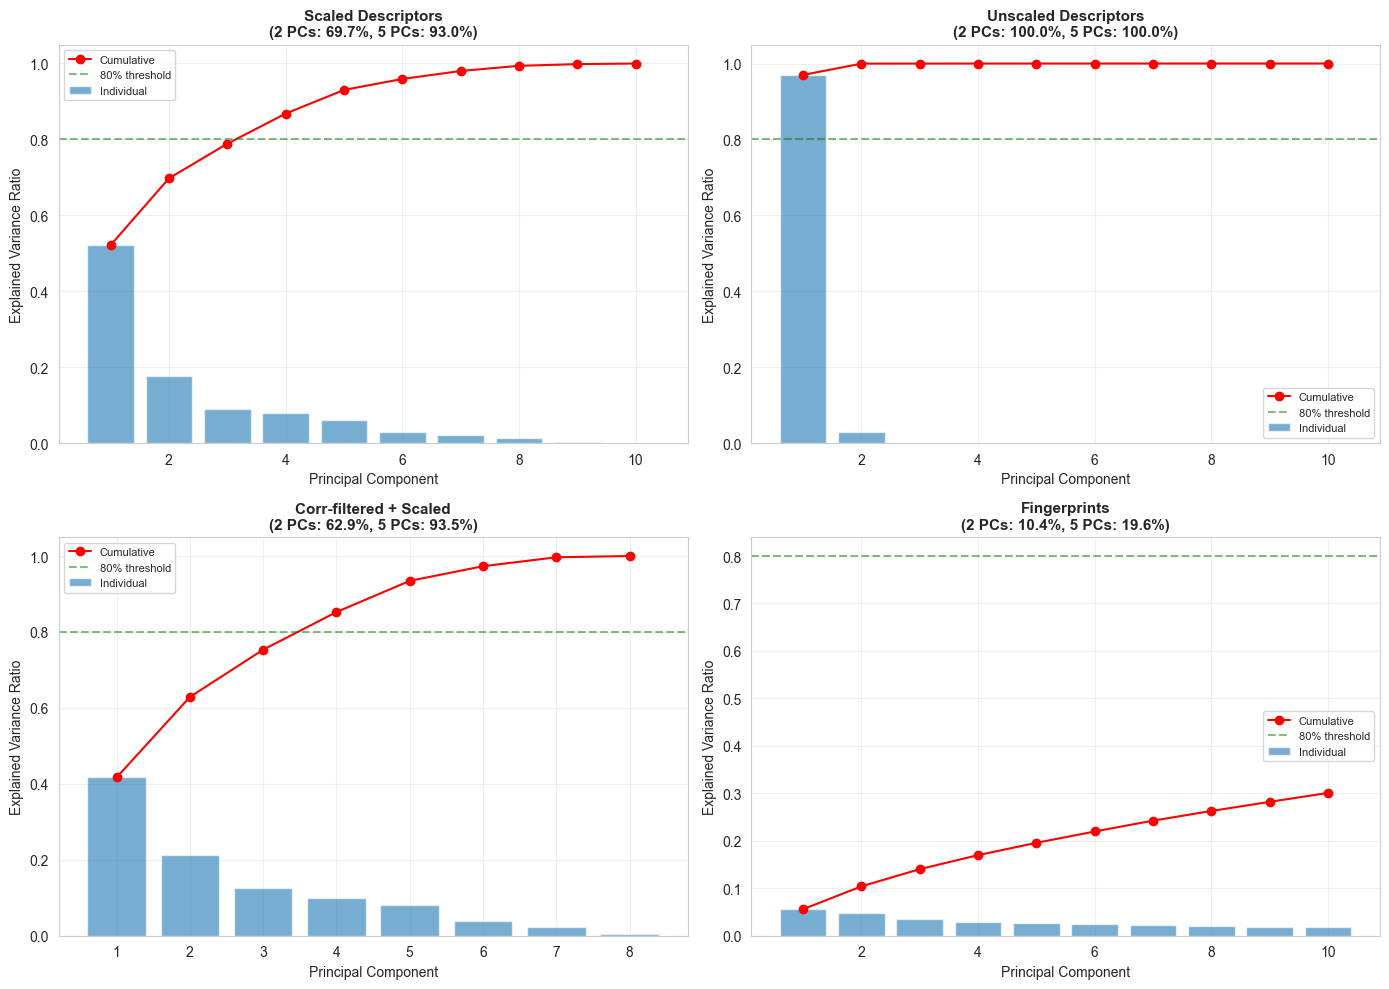

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot cumulative variance explained
results = [
    (pca_desc_scaled, "Scaled Descriptors", axes[0, 0]),
    (pca_desc_unscaled, "Unscaled Descriptors", axes[0, 1]),
    (pca_desc_cf, "Corr-filtered + Scaled", axes[1, 0]),
    (pca_fp, "Fingerprints", axes[1, 1])
]

for pca, label, ax in results:
    ev = pca.explained_variance_ratio_
    cumsum = np.cumsum(ev)
    
    ax.bar(range(1, len(ev)+1), ev, alpha=0.6, label='Individual')
    ax.plot(range(1, len(ev)+1), cumsum, 'ro-', label='Cumulative')
    ax.axhline(y=0.8, color='g', linestyle='--', alpha=0.5, label='80% threshold')
    ax.set_xlabel('Principal Component', fontsize=10)
    ax.set_ylabel('Explained Variance Ratio', fontsize=10)
    ax.set_title(f'{label}\n(2 PCs: {ev[:2].sum():.1%}, 5 PCs: {ev[:5].sum():.1%})', 
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

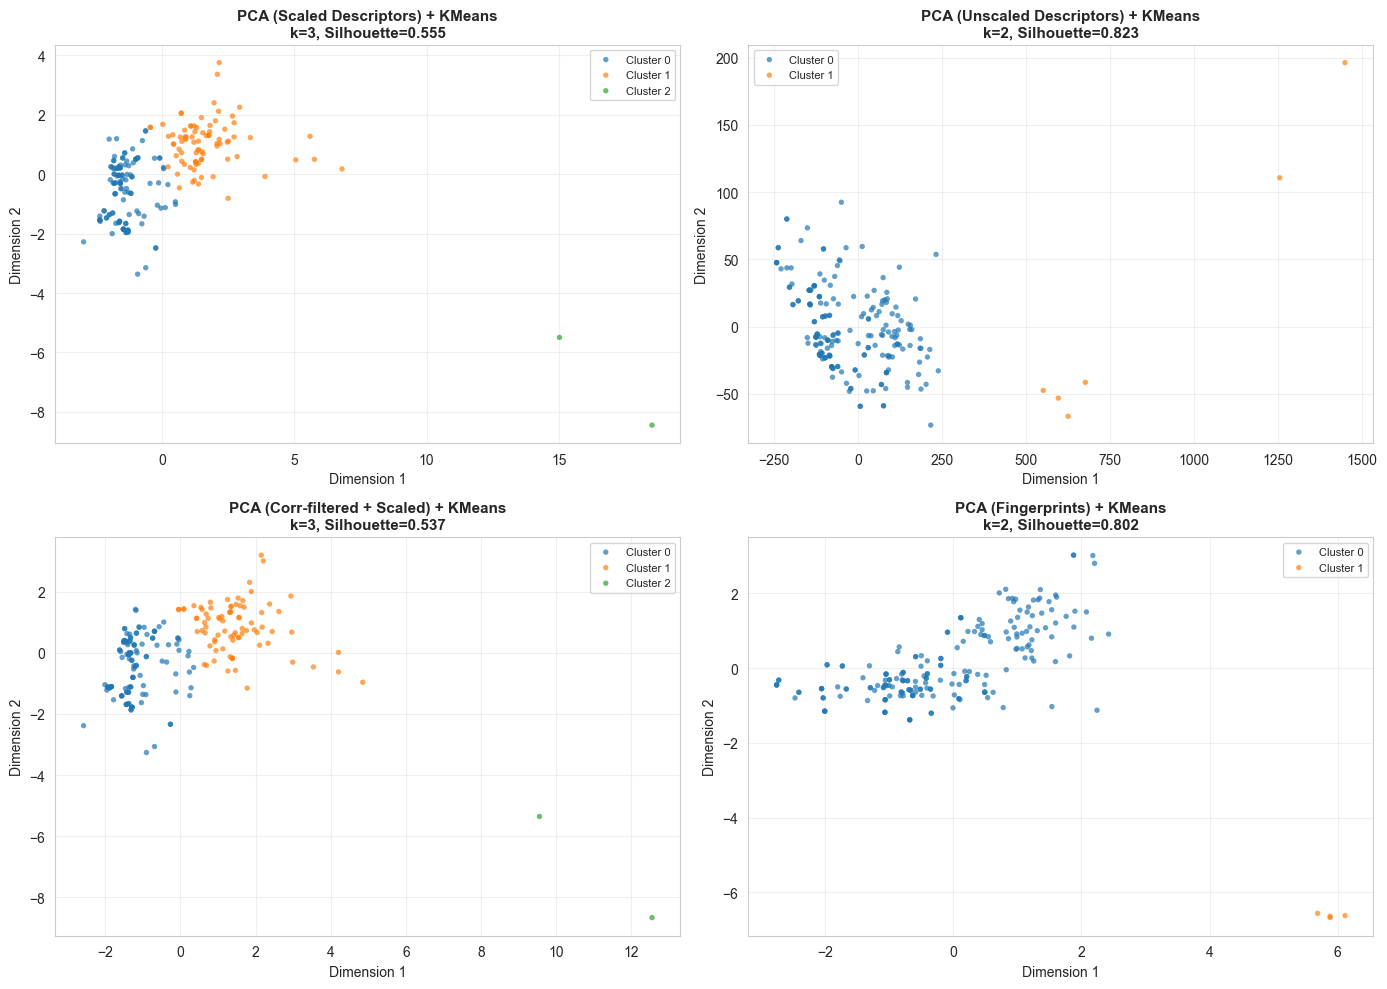

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot clustering results
scatter_data = [
    (Z_desc_scaled, best_s, "Scaled Descriptors", axes[0, 0]),
    (Z_desc_unscaled, best_u, "Unscaled Descriptors", axes[0, 1]),
    (Z_desc_cf, best_cf, "Corr-filtered + Scaled", axes[1, 0]),
    (Z_fp, best_fp, "Fingerprints", axes[1, 1])
]

for Z, best, label, ax in scatter_data:
    if best:
        labels = best[2]
        sil = best[0]
        k = best[1]
        title = f"PCA ({label}) + KMeans\nk={k}, Silhouette={sil:.3f}"
    else:
        labels = None
        title = f"PCA ({label})"
    
    scatter2d_enhanced(Z[:, :2], labels=labels, title=title, ax=ax, 
                      highlight_noise=False, show_legend=(k <= 8) if best else False)

plt.tight_layout()
plt.show()

In [35]:
# Compare feature ranges before and after scaling
print("\nDescriptor statistics (before scaling):")
print(f"  Min: {df_desc.values.min():.4f}")
print(f"  Max: {df_desc.values.max():.4f}")
print(f"  Mean: {df_desc.values.mean():.4f}")
print(f"  Std: {df_desc.values.std():.4f}")

print("\nDescriptor statistics (after scaling):")
print(f"  Min: {X_desc_scaled_full.min():.4f}")
print(f"  Max: {X_desc_scaled_full.max():.4f}")
print(f"  Mean: {X_desc_scaled_full.mean():.4f}")
print(f"  Std: {X_desc_scaled_full.std():.4f}")

# Check if scaling made a difference
print("\nDoes scaling matter for PCA?")
print(f"  Unscaled - PC1 variance: {pca_desc_unscaled.explained_variance_ratio_[0]:.3f}")
print(f"  Scaled - PC1 variance: {pca_desc_scaled.explained_variance_ratio_[0]:.3f}")
print(f"  Difference: {abs(pca_desc_unscaled.explained_variance_ratio_[0] - pca_desc_scaled.explained_variance_ratio_[0]):.3f}")


Descriptor statistics (before scaling):
  Min: -8.1483
  Max: 1681.9150
  Mean: 44.1755
  Std: 123.1855

Descriptor statistics (after scaling):
  Min: -6.5573
  Max: 14.4222
  Mean: -0.0000
  Std: 1.0000

Does scaling matter for PCA?
  Unscaled - PC1 variance: 0.970
  Scaled - PC1 variance: 0.521
  Difference: 0.449


In [36]:
comparison_df = pd.DataFrame([
    {
        "Method": "Scaled Descriptors",
        "N Features": df_desc.shape[1],
        "PC1+PC2 Variance": f"{pca_desc_scaled.explained_variance_ratio_[:2].sum():.3f}",
        "KMeans Silhouette": f"{best_s[0]:.4f}" if best_s else "N/A",
        "Optimal K": best_s[1] if best_s else "N/A"
    },
    {
        "Method": "Unscaled Descriptors",
        "N Features": df_desc.shape[1],
        "PC1+PC2 Variance": f"{pca_desc_unscaled.explained_variance_ratio_[:2].sum():.3f}",
        "KMeans Silhouette": f"{best_u[0]:.4f}" if best_u else "N/A",
        "Optimal K": best_u[1] if best_u else "N/A"
    },
    {
        "Method": "Corr-filtered + Scaled",
        "N Features": df_desc_cf.shape[1],
        "PC1+PC2 Variance": f"{pca_desc_cf.explained_variance_ratio_[:2].sum():.3f}",
        "KMeans Silhouette": f"{best_cf[0]:.4f}" if best_cf else "N/A",
        "Optimal K": best_cf[1] if best_cf else "N/A"
    },
    {
        "Method": "Fingerprints",
        "N Features": X_fp.shape[1],
        "PC1+PC2 Variance": f"{pca_fp.explained_variance_ratio_[:2].sum():.3f}",
        "KMeans Silhouette": f"{best_fp[0]:.4f}" if best_fp else "N/A",
        "Optimal K": best_fp[1] if best_fp else "N/A"
    }
])

display(comparison_df)

,Method,N Features,PC1+PC2 Variance,KMeans Silhouette,Optimal K
0,Scaled Descriptors,11,0.697,0.5550,3
1,Unscaled Descriptors,11,1.000,0.8232,2
2,Corr-filtered + Scaled,8,0.629,0.5369,3
3,Fingerprints,2048,0.104,0.8017,2


## 9. Structural inspection of clusters & outliers

We visualize representative molecules **per cluster** (medoids) and **outliers/noise** (from HDBSCAN). This lets us answer whether DR grouped **structurally similar** compounds and to spot **potential outliers**.

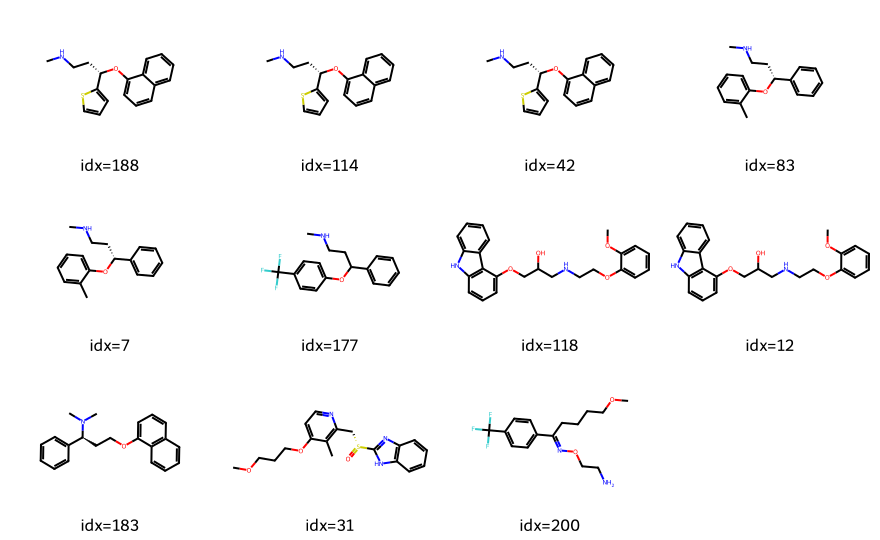

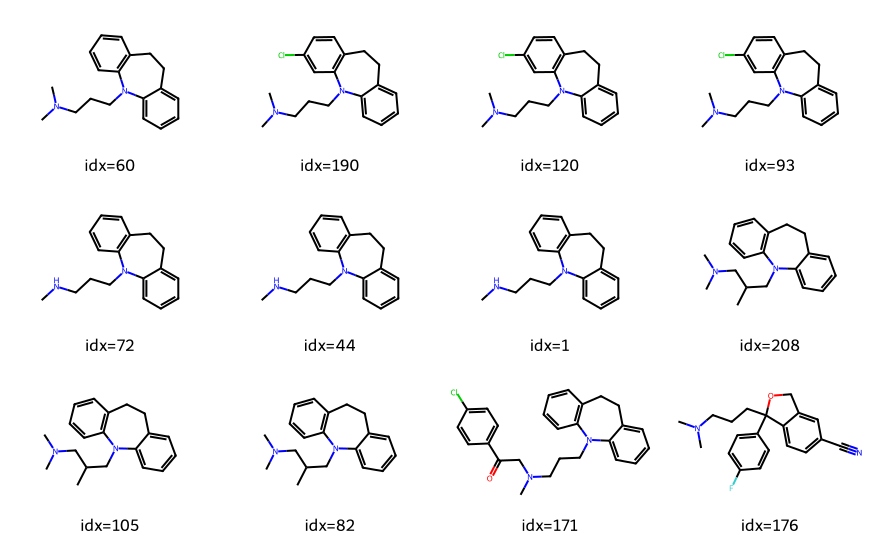

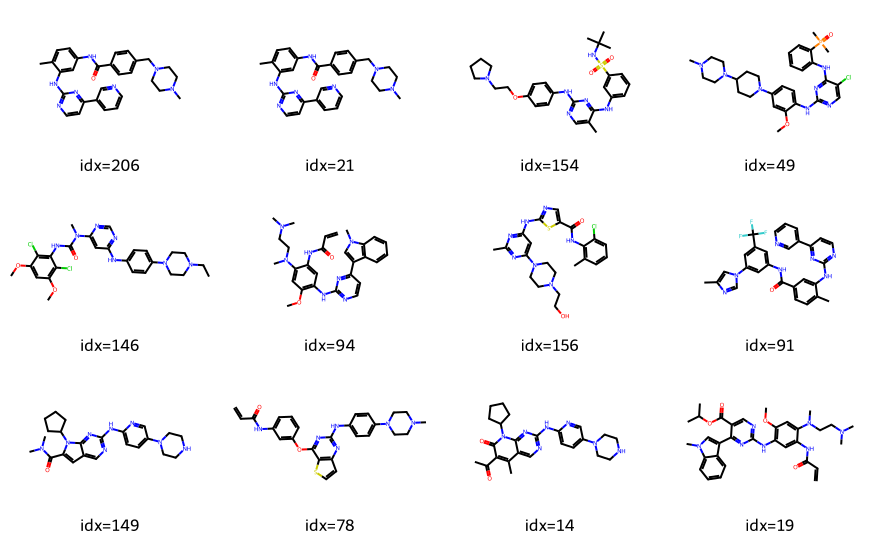

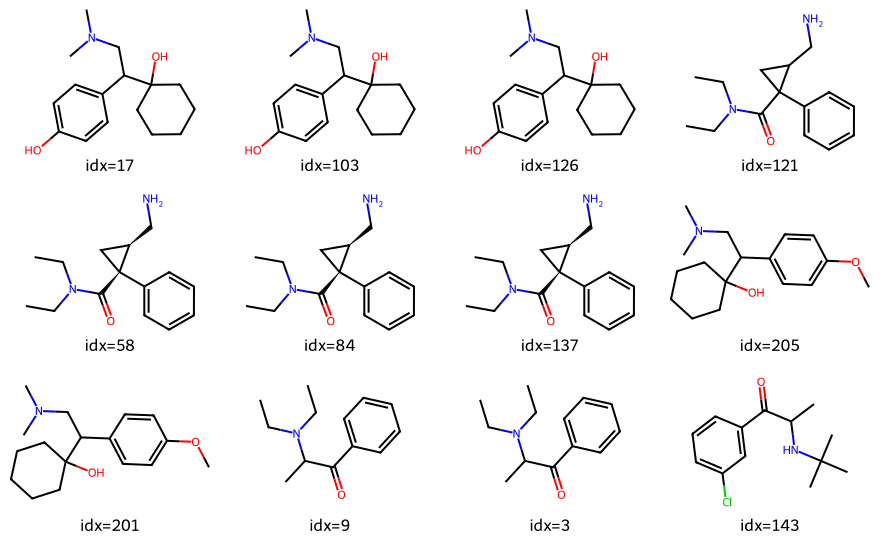

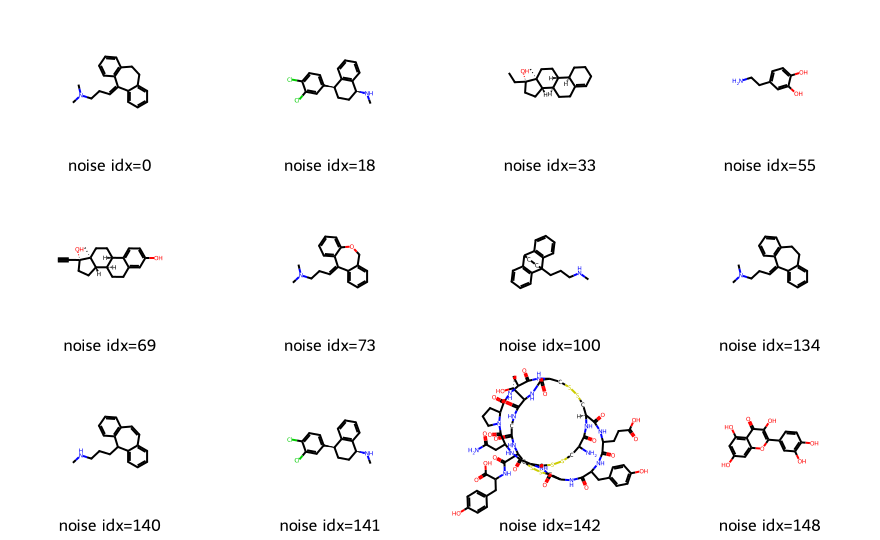

In [37]:
from rdkit.Chem import Draw
from IPython.display import display, SVG

def cluster_indices(labels, cluster_id):
    return np.where(labels == cluster_id)[0]

def medoid_indices(fps, idxs, topn=6):
    # medoids by maximizing mean similarity to others in the cluster
    if len(idxs) == 0:
        return []
    sims_matrix = []
    for i in idxs:
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], [fps[j] for j in idxs])
        sims_matrix.append(np.mean(sims))
    order = np.argsort(sims_matrix)[::-1]
    return [int(idxs[i]) for i in order[:topn]]

# Choose a labeling to inspect (UMAP+HDBSCAN preferred)
labels_for_view = best_umap["hdbscan_labels"] if best_umap else None
Z_for_view = best_umap["Z"] if best_umap else None

if labels_for_view is not None:
    # Show up to 4 clusters
    cl_ids = [c for c in sorted(set(labels_for_view)) if c != -1][:4]
    for cid in cl_ids:
        idxs = cluster_indices(labels_for_view, cid)
        meds = medoid_indices(fps, idxs, topn=12)
        mols_show = [mols_u[i] for i in meds]
        legends = [f"idx={i}" for i in meds]
        img = Draw.MolsToGridImage(mols_show, molsPerRow=4, subImgSize=(220, 180), legends=legends, useSVG=True)
        display(SVG(img.data if hasattr(img, "data") else img))

    # Outliers (noise = -1)
    noise_idxs = cluster_indices(labels_for_view, -1)
    if len(noise_idxs) > 0:
        sel = noise_idxs[:12]
        mols_show = [mols_u[i] for i in sel]
        legends = [f"noise idx={i}" for i in sel]
        img = Draw.MolsToGridImage(mols_show, molsPerRow=4, subImgSize=(220, 180), legends=legends, useSVG=True)
        display(SVG(img.data if hasattr(img, "data") else img))


## 10. PCA: fingerprints vs descriptors; scaling & feature selection effects

We directly compare PCA plots and metrics using **fingerprints** vs **descriptors**, and study the effect of **scaling** and **feature selection** before PCA.

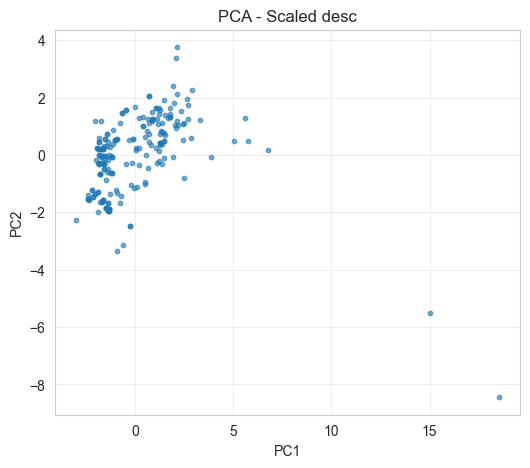

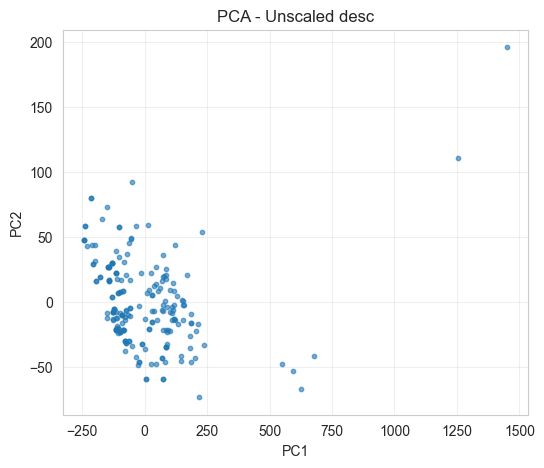

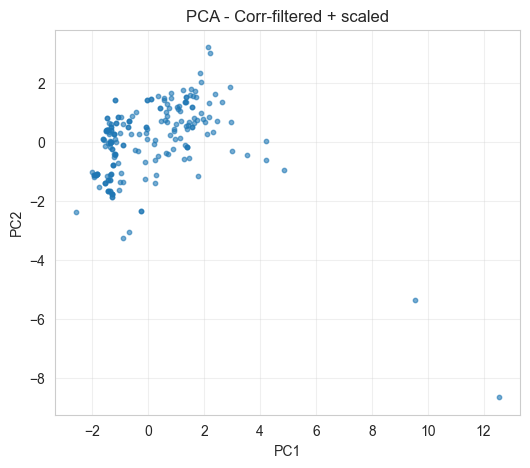

KMeans best K on PCA(FP 2D): 2 silhouette: 0.8017414411053558
KMeans best K on PCA(Desc scaled 2D): 3 silhouette: 0.5549871926152097


In [38]:
# Fingerprints (binary) -> PCA 2D
pca_fp2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X_fp)
dfk_fp2, best_fp2 = kmeans_sweep(pca_fp2, k_range=range(2, 16))

# Descriptors variants already computed: Z_desc_scaled, Z_desc_unscaled, Z_desc_cf
def compare_three(ZA, ZB, ZC, names=("Scaled desc", "Unscaled desc", "Corr-filtered + scaled")):
    plt.figure(); scatter2d(ZA[:, :2], title=f"PCA - {names[0]}"); plt.show()
    plt.figure(); scatter2d(ZB[:, :2], title=f"PCA - {names[1]}"); plt.show()
    plt.figure(); scatter2d(ZC[:, :2], title=f"PCA - {names[2]}"); plt.show()

def scatter2d(data, title="", s=10, alpha=0.6, c=None, cmap='viridis'):
    plt.scatter(data[:, 0], data[:, 1], s=s, alpha=alpha, c=c, cmap=cmap)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar() if c is not None else None
    plt.grid(True, alpha=0.3)

compare_three(Z_desc_scaled, Z_desc_unscaled, Z_desc_cf)

print("KMeans best K on PCA(FP 2D):", best_fp2[1], "silhouette:", best_fp2[0])
print("KMeans best K on PCA(Desc scaled 2D):", best_s[1], "silhouette:", best_s[0])


# 2. Clustering Active and Inactive Molecules

The `Q99685_papyrus.tsv` file contains bioactivity data for 700 compounds from the [Papyrus](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-022-00672-x) data set. The molecules were measured for inhibition of monoglyceride lipase (MGLL, [Q99685](https://www.uniprot.org/uniprotkb/Q99685/entry)). Use your knowledge of clustering methods to cluster the molecules in the data set.

Try to find answers to the following questions and support your answers with data and code:

- Can you find clusters associated with higher ratio of more active molecules? Discuss a few examples.
- If you use a dimensionality reduction method to plot the chemical space, do you obtain similar results as with the clustering method? Do you see compounds belonging to one cluster close to one another in the chemical space depiction as well? If not, why do you think that is?

#### Answer: We identified multiple chemotype‑level clusters enriched in MGLL activity. At pChEMBL ≥ 7 (≤100 nM), 7 clusters were significant at q ≤ 0.05, led by a large, robust series (cluster 6, n = 43; 93.0% active; OR = 24.95; q = 7.33e‑15; 95% CI [0.814, 0.976]). This series remains enriched at pChEMBL ≥ 8 (≤10 nM; 62.8% active; OR = 12.86; q = 7.03e‑13). Additional enriched clusters include 15, 16, 8, and 9 at 100 nM, while cluster 10 is uniformly active at 1 µM but loses enrichment at stricter thresholds—consistent with a mid‑µM series.
#### 2D chemical‑space views (UMAP/t‑SNE) broadly agree with the clustering (UMAP: ARI = 0.63, NMI = 0.87; t‑SNE: ARI = 0.68, NMI = 0.89; 2D silhouettes ~0.62–0.71). Enriched clusters form contiguous regions in 2D, with minor discrepancies attributable to projection distortion, variable density/noise handling, and activity cliffs. Overall, the 2D plots corroborate the clustering‑based structure–activity segmentation.

In [3]:
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors, rdMolTransforms
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.rdmolops import FastFindRings
from rdkit.Chem import Draw
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
from rdkit.Chem.MolStandardize import rdMolStandardize

RDLogger.DisableLog('rdApp.*')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import math
from dataclasses import dataclass
import itertools
import random
from collections import Counter, defaultdict

from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics import pairwise_distances
from sklearn.manifold import trustworthiness, TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import umap
import hdbscan
from statsmodels.stats.multitest import multipletests
from scipy.stats import fisher_exact
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [4]:
# ---- Configuration ----
from types import SimpleNamespace

CFG = dict(
    data_path="Q99685_papyrus.tsv",   # Update if file is elsewhere
    out_dir="outputs",

    # Labels (pChEMBL thresholds)
    thresholds=[6.0, 7.0, 8.0],

    # Fingerprints
    fp_kind="morgan",
    fp_radius_primary=3,     # ECFP6
    fp_radius_secondary=2,   # ECFP4 sensitivity
    fp_nbits=2048,
    fp_use_chirality=True,

    # Distances
    knn_k=50,

    # Clustering sweeps
    butina_sim_cutoffs=[0.55, 0.60, 0.65, 0.70],
    hdbscan_min_cluster_size=[10, 15],
    hdbscan_min_samples=[None, 5],
    kmedoids_k=[10, 15, 20, 25, 30],

    # Embedding sweeps
    umap_n_neighbors=[15, 30, 50],
    umap_min_dist=[0.0, 0.1, 0.3],
    umap_n_components=[2, 3],
    tsne_perplexity=[30, 50],
    tsne_n_components=[2, 3],

    # General
    random_state=42,
    max_mcs_time=10,  # seconds per MCS attempt
    permutation_iters=200,  # label-shuffling baseline
)

CFG = SimpleNamespace(**CFG)
Path(CFG.out_dir).mkdir(parents=True, exist_ok=True)

In [6]:
# ---- Data load & basic audit ----
from pathlib import Path

data_path = Path(CFG.data_path)
if not data_path.exists():
    alt = Path.cwd() / "Q99685_papyrus.tsv"
    data_path = alt

df = pd.read_csv(data_path, sep='\t')
print(df.shape)
print(df.columns.tolist())
df.head(3)

(700, 32)
['Activity_ID', 'Quality', 'source', 'CID', 'SMILES', 'connectivity', 'InChIKey', 'InChI', 'InChI_AuxInfo', 'target_id', 'TID', 'accession', 'Protein_Type', 'AID', 'doc_id', 'Year', 'all_doc_ids', 'all_years', 'type_IC50', 'type_EC50', 'type_KD', 'type_Ki', 'type_other', 'Activity_class', 'relation', 'pchembl_value', 'pchembl_value_Mean', 'pchembl_value_StdDev', 'pchembl_value_SEM', 'pchembl_value_N', 'pchembl_value_Median', 'pchembl_value_MAD']


,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,type_other,Activity_class,relation,pchembl_value,pchembl_value_Mean,pchembl_value_StdDev,pchembl_value_SEM,pchembl_value_N,pchembl_value_Median,pchembl_value_MAD
0,AADKPDGTJHDJAJ_on_Q99685_WT,High,ChEMBL31,ChEMBL31.compound.177735;ChEMBL31.compound.177...,O=C(Cc1ccc(Cc2ccccc2)cc1)OCC1CO1,AADKPDGTJHDJAJ,AADKPDGTJHDJAJ-UHFFFAOYSA-N,InChI=1S/C18H18O3/c19-18(21-13-17-12-20-17)11-...,"""AuxInfo=1/0/N:12,11,13,10,14,6,15,5,16,8,3,20...",Q99685_WT,...,NaN,NaN,=,5.62;4.8;4.4;4.81;5.61;5.62;4.8;4.4;4.81;5.61;...,5.048,0.498647,0.111501,20.0,4.81,0.41
1,AAVJAASROXWJAI_on_Q99685_WT,High,ChEMBL31,ChEMBL31.compound.399047,CCCCCCCCCC(=NO)c1c(O)ccc(-c2ccc(OC)cc2)c1,AAVJAASROXWJAI,AAVJAASROXWJAI-UHFFFAOYSA-N,InChI=1S/C23H31NO3/c1-3-4-5-6-7-8-9-10-22(24-2...,"""AuxInfo=1/0/N:1,24,2,3,4,5,6,7,8,9,20,26,17,2...",Q99685_WT,...,NaN,NaN,=,4.44;4.44,4.440,0.000000,0.000000,2.0,4.44,0.00
2,AAZGPNZTJLHQJM_on_Q99685_WT,High,ExCAPE-DB,599019;ChEMBL31.compound.123531;599019;ChEMBL3...,O=C1C=CC(=O)N1c1ccccc1I,AAZGPNZTJLHQJM,AAZGPNZTJLHQJM-UHFFFAOYSA-N,InChI=1S/C10H6INO2/c11-7-3-1-2-4-8(7)12-9(13)5...,"""AuxInfo=1/0/N:11,10,12,9,3,4,13,8,2,5,14,7,1,...",Q99685_WT,...,NaN,NaN,=,5.3;5.3;5.3;5.3;5.3;5.3;5.3;5.3,5.300,0.000000,0.000000,8.0,5.30,0.00


Rows: 700
pChEMBL ≥ 6.0: 404/700 (57.7%) actives
pChEMBL ≥ 7.0: 248/700 (35.4%) actives
pChEMBL ≥ 8.0: 102/700 (14.6%) actives


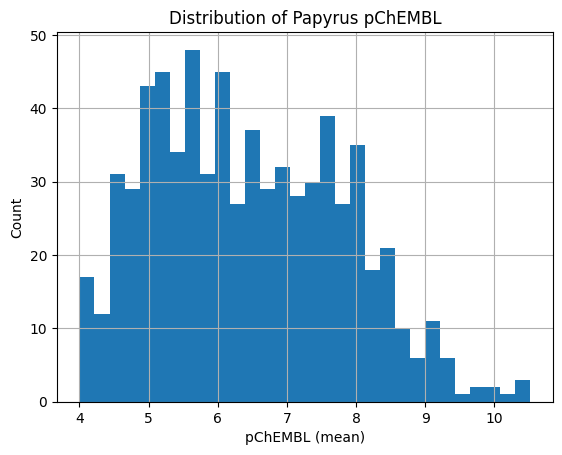

In [7]:
n = len(df)
print("Rows:", n)

# Basic label counts for thresholds
for thr in CFG.thresholds:
    active = (df['pchembl_value_Mean'] >= thr).sum()
    print(f"pChEMBL ≥ {thr:.1f}: {active}/{n} ({active/n:.1%}) actives")

# Histogram of pChEMBL
plt.figure()
df['pchembl_value_Mean'].hist(bins=30)
plt.xlabel("pChEMBL (mean)")
plt.ylabel("Count")
plt.title("Distribution of Papyrus pChEMBL")
plt.show()

In [9]:
# ---- Standardization utilities ----
def standardize_smiles(smiles: str):
    if pd.isna(smiles) or not isinstance(smiles, str):
        return None, "NA"
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None, "MolFromSmilesFailed"

        # 1) Disconnect metals
        disconnector = rdMolStandardize.MetalDisconnector()
        mol = disconnector.Disconnect(mol)
        # 2) Normalize
        normalizer = rdMolStandardize.Normalizer()
        mol = normalizer.normalize(mol)
        # 3) Reionize / neutralize
        reionizer = rdMolStandardize.Reionizer()
        mol = reionizer.reionize(mol)
        # 4) Uncharger (neutralize where appropriate)
        uncharger = rdMolStandardize.Uncharger()
        mol = uncharger.uncharge(mol)
        Chem.SanitizeMol(mol)
        can = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
        return mol, can
    except Exception as e:
        return None, f"StandardizeError:{e}"

def prepare_mols(df, smiles_col='SMILES'):
    smiles_col = smiles_col if smiles_col in df.columns else 'smiles' if 'smiles' in df.columns else 'SMILES'
    mols, cans, errs = [], [], []
    for s in tqdm(df[smiles_col].tolist(), desc="Standardizing"):
        mol, can = standardize_smiles(s)
        mols.append(mol)
        cans.append(can if isinstance(can, str) else None)
        errs.append(can if isinstance(can, str) == False else "OK")
    sdf = df.copy().reset_index(drop=True)
    sdf['SMILES_std'] = cans
    sdf['std_status'] = ["OK" if isinstance(e, str) and e=="OK" else e for e in errs]
    sdf['mol'] = mols
    # Drop failures
    ok_mask = sdf['mol'].notna()
    if ok_mask.sum() < len(sdf):
        print(f"Dropping {len(sdf)-ok_mask.sum()} molecules that failed standardization")
    sdf = sdf.loc[ok_mask].reset_index(drop=True)
    return sdf

In [10]:
# ---- Run standardization ----
sdf = prepare_mols(df, smiles_col='SMILES' if 'SMILES' in df.columns else df.columns[0])
print(sdf.shape)
sdf[['SMILES', 'SMILES_std', 'std_status']].head(3)

Standardizing: 100%|██████████| 700/700 [00:00<00:00, 1180.34it/s]

(700, 35)


,SMILES,SMILES_std,std_status
0,O=C(Cc1ccc(Cc2ccccc2)cc1)OCC1CO1,O=C(Cc1ccc(Cc2ccccc2)cc1)OCC1CO1,OK
1,CCCCCCCCCC(=NO)c1c(O)ccc(-c2ccc(OC)cc2)c1,CCCCCCCCCC(=NO)c1cc(-c2ccc(OC)cc2)ccc1O,OK
2,O=C1C=CC(=O)N1c1ccccc1I,O=C1C=CC(=O)N1c1ccccc1I,OK


In [11]:
# ---- Fingerprints & descriptors ----
from rdkit.Chem import rdMolDescriptors

def morgan_fp(mol, radius=3, nBits=2048, use_chirality=True):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, useChirality=use_chirality)

def fps_from_mols(mols, radius=3, nBits=2048, use_chirality=True):
    fps = [morgan_fp(m, radius=radius, nBits=nBits, use_chirality=use_chirality) for m in mols]
    return fps

def fp_to_numpy(fps):
    arr = np.zeros((len(fps), CFG.fp_nbits), dtype=bool)
    for i, fp in enumerate(fps):
        # faster than ConvertToNumpyArray for bool target
        onbits = list(fp.GetOnBits())
        arr[i, onbits] = True
    return arr

def physchem_df(mols):
    rows = []
    for m in mols:
        rows.append(dict(
            MW=Descriptors.MolWt(m),
            LogP=Descriptors.MolLogP(m),
            TPSA=Descriptors.TPSA(m),
            HBD=Descriptors.NumHDonors(m),
            HBA=Descriptors.NumHAcceptors(m),
            RotB=Descriptors.NumRotatableBonds(m),
            Rings=rdMolDescriptors.CalcNumRings(m),
            FracCSP3=rdMolDescriptors.CalcFractionCSP3(m),
        ))
    return pd.DataFrame(rows)

# Primary ECFP6
fps6 = fps_from_mols(sdf['mol'].tolist(), radius=CFG.fp_radius_primary, nBits=CFG.fp_nbits, use_chirality=CFG.fp_use_chirality)
X_bin = fp_to_numpy(fps6)

# Sensitivity ECFP4
fps4 = fps_from_mols(sdf['mol'].tolist(), radius=CFG.fp_radius_secondary, nBits=CFG.fp_nbits, use_chirality=CFG.fp_use_chirality)
X_bin_ecfp4 = fp_to_numpy(fps4)

# Descriptors
X_desc = physchem_df(sdf['mol'].tolist())

print("Binary FP shape (ECFP6):", X_bin.shape, "Descriptors:", X_desc.shape)

Binary FP shape (ECFP6): (700, 2048) Descriptors: (700, 8)


In [12]:
# ---- Labels ----
y_cont = sdf['pchembl_value_Mean'].to_numpy()
labels = {thr: (y_cont >= thr).astype(int) for thr in CFG.thresholds}
for thr, yb in labels.items():
    print(f"Threshold {thr:.1f} active %: {yb.mean():.1%}")

Threshold 6.0 active %: 57.7%
Threshold 7.0 active %: 35.4%
Threshold 8.0 active %: 14.6%


In [13]:
# ---- Tanimoto distances (full matrix) ----
def tanimoto_condensed(fps):
    n = len(fps)
    dists = []
    for i in tqdm(range(n), desc="Tanimoto upper-tri"):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[i+1:])
        dists.extend([1.0 - s for s in sims])
    return np.array(dists, dtype=np.float32)

def condensed_to_square(dists, n):
    D = np.zeros((n, n), dtype=np.float32)
    idx = 0
    for i in range(n):
        for j in range(i+1, n):
            D[i, j] = D[j, i] = dists[idx]
            idx += 1
    return D

D_condensed = tanimoto_condensed(fps6)
D = condensed_to_square(D_condensed, len(fps6))
print("Distance matrix shape:", D.shape, "min/max:", D.min(), D.max())

Tanimoto upper-tri: 100%|██████████| 700/700 [00:00<00:00, 6824.73it/s]

Distance matrix shape: (700, 700) min/max: 0.0 1.0


In [14]:
# ---- Butina clustering ----
def butina_cluster_from_condensed(dists_condensed, n, sim_cutoff=0.6):
    # Butina uses distance threshold; set as 1 - similarity cutoff.
    dist_cutoff = 1.0 - float(sim_cutoff)
    clusters = Butina.ClusterData(dists_condensed, n, dist_cutoff, isDistData=True)
    labels = -1 * np.ones(n, dtype=int)
    for cid, members in enumerate(clusters):
        for idx in members:
            labels[idx] = cid
    return labels, clusters

lbls_but, cl_but = butina_cluster_from_condensed(D_condensed, D.shape[0], sim_cutoff=0.6)
n_clusters_but = len(set(lbls_but)) if len(lbls_but) else 0
print("Butina clusters:", n_clusters_but)

Butina clusters: 212


In [15]:
def hdbscan_cluster(Xbin, min_cluster_size=10, min_samples=None, random_state=42):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,
                                metric='jaccard', cluster_selection_method='eom', prediction_data=False)
    labels = clusterer.fit_predict(Xbin)
    return labels, clusterer

In [16]:
# ---- Metrics & enrichment ----
from math import log2

def cluster_basic_stats(labels):
    # assumes -1 reserved for noise (HDBSCAN). For Butina/KMedoids, no -1
    mask = labels >= 0
    valid_labels = labels[mask]
    counts = Counter(valid_labels.tolist())
    sizes = np.array(list(counts.values()), dtype=int)
    n_clusters = len(counts)
    n_noise = np.sum(labels < 0)
    size_entropy = -np.sum((sizes/sizes.sum()) * np.log2(sizes/sizes.sum() + 1e-12)) if n_clusters>0 else 0.0
    return dict(n_clusters=n_clusters, n_noise=int(n_noise), size_mean=float(sizes.mean() if n_clusters>0 else 0.0),
                size_std=float(sizes.std() if n_clusters>0 else 0.0), size_entropy=float(size_entropy))

def silhouette_from_distance(D, labels):
    # scikit-learn silhouette_score supports metric='precomputed'
    mask = labels >= 0  # exclude noise for silhouette
    if np.unique(labels[mask]).size < 2:
        return np.nan
    return float(silhouette_score(D[np.ix_(mask, mask)], labels[mask], metric='precomputed'))

def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (0.0, 0.0)
    p = k / n
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    adj = z * math.sqrt((p*(1-p) + z**2/(4*n)) / n) / denom
    return (max(0.0, center - adj), min(1.0, center + adj))

def enrichment_table(labels, y_binary, alpha=0.05):
    # labels: array of cluster ids (>=0), y_binary: 0/1 (same length)
    out = []
    N = len(labels)
    background_active = int(y_binary.sum())
    for cid in sorted(set(labels[labels>=0].tolist())):
        idx = np.where(labels==cid)[0]
        n = len(idx)
        a = int(y_binary[idx].sum())
        b = n - a
        c = background_active - a
        d = (N - background_active) - b
        # 2x2 Fisher test
        _, p = fisher_exact([[a, b], [c, d]], alternative='greater')
        ratio = a/n if n>0 else 0.0
        ci_low, ci_high = wilson_ci(a, n)
        # odds ratio from contingency (add 0.5 to avoid zero-division)
        or_est = ((a+0.5)*(d+0.5))/((b+0.5)*(c+0.5))
        out.append(dict(cluster_id=cid, n=n, actives=a, ratio=ratio, OR=or_est, pvalue=p, ci_low=ci_low, ci_high=ci_high))
    # FDR
    if out:
        pvals = [r['pvalue'] for r in out]
        rej, qvals, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
        for r, q, keep in zip(out, qvals, rej):
            r['qvalue'] = q
            r['significant'] = bool(keep)
    return pd.DataFrame(out).sort_values(['qvalue', 'OR', 'ratio'], ascending=[True, False, False], na_position='last')

def permutation_baseline(labels, y_binary, iters=200, seed=42):
    rng = np.random.default_rng(seed)
    labels = labels.copy()
    mask = labels >= 0
    yb = y_binary.copy()
    metrics = []
    for _ in tqdm(range(iters), desc="Permutations"):
        rng.shuffle(yb)
        et = enrichment_table(labels, yb, alpha=0.05)
        if len(et):
            best_q = et['qvalue'].min()
            best_or = et['OR'].max()
            metrics.append((best_q, best_or))
    if metrics:
        arr = np.array(metrics)
        return pd.DataFrame(dict(best_q=arr[:,0], best_or=arr[:,1]))
    else:
        return pd.DataFrame(columns=['best_q','best_or'])

In [17]:
# ---- Parameter sweeps ----
results = []

# Butina sweep
for sc in CFG.butina_sim_cutoffs:
    labels_b, _ = butina_cluster_from_condensed(D_condensed, D.shape[0], sim_cutoff=sc)
    stats = cluster_basic_stats(labels_b)
    sil = silhouette_from_distance(D, labels_b)
    row = dict(method="butina", sim_cutoff=sc, silhouette=sil, **stats)
    # enrichment counts for thresholds
    for thr in CFG.thresholds:
        et = enrichment_table(labels_b, (y_cont >= thr).astype(int))
        row[f"enriched_q05_p{thr}"] = int((et['qvalue']<=0.05).sum()) if len(et) else 0
    results.append(row)

# HDBSCAN sweep
for mcs in CFG.hdbscan_min_cluster_size:
    for ms in CFG.hdbscan_min_samples:
        labels_h, _ = hdbscan_cluster(X_bin, min_cluster_size=mcs, min_samples=ms, random_state=CFG.random_state)
        stats = cluster_basic_stats(labels_h)
        sil = silhouette_from_distance(D, labels_h)
        row = dict(method="hdbscan", min_cluster_size=mcs, min_samples=(ms if ms is not None else "None"), silhouette=sil, **stats)
        for thr in CFG.thresholds:
            et = enrichment_table(labels_h, (y_cont >= thr).astype(int))
            row[f"enriched_q05_p{thr}"] = int((et['qvalue']<=0.05).sum()) if len(et) else 0
        results.append(row)

res_df = pd.DataFrame(results).sort_values(['silhouette','n_clusters'], ascending=[False, False])
res_df.reset_index(drop=True, inplace=True)
res_df

,method,sim_cutoff,silhouette,n_clusters,n_noise,size_mean,size_std,size_entropy,enriched_q05_p6.0,enriched_q05_p7.0,enriched_q05_p8.0,min_cluster_size,min_samples
0,hdbscan,NaN,0.356392,9,329,41.222222,28.882050,2.910525,5,5,3,15.0,None
1,hdbscan,NaN,0.345690,14,259,31.500000,27.139191,3.425428,7,6,2,10.0,None
2,hdbscan,NaN,0.293813,14,195,36.071429,26.160123,3.519485,8,7,4,15.0,5
3,hdbscan,NaN,0.292963,17,165,31.470588,25.736487,3.722669,8,7,3,10.0,5
4,butina,0.70,-0.376606,350,0,2.000000,1.853183,8.016912,0,0,0,NaN,NaN
5,butina,0.55,-0.394916,170,0,4.117647,6.068068,6.443927,0,0,0,NaN,NaN
6,butina,0.60,-0.411884,212,0,3.301887,4.492488,6.899697,0,0,0,NaN,NaN
7,butina,0.65,-0.415853,263,0,2.661597,2.997389,7.419842,0,0,0,NaN,NaN


In [18]:
# ---- Model selection: score and pick top candidates ----
def normalize_series(s):
    s = s.copy()
    s = (s - np.nanmin(s)) / (np.nanmax(s) - np.nanmin(s) + 1e-12)
    s = s.fillna(0.0)
    return s

rdf = res_df.copy()

# Create a composite score: normalized silhouette + normalized (#enriched at p>=7) - normalized noise proportion
comp = []
enrich_col = 'enriched_q05_p7.0' if 'enriched_q05_p7.0' in rdf.columns else [c for c in rdf.columns if 'enriched_q05_p7' in c][0]
rdf['noise_prop'] = rdf['n_noise'] / (len(sdf) + 1e-9)
for i, row in rdf.iterrows():
    sil = row['silhouette']
    enr = row[enrich_col]
    nz = row['noise_prop']
    comp.append(dict(idx=i, silhouette=sil, enriched=enr, noise=nz))
comp_df = pd.DataFrame(comp)
comp_df['sil_n'] = normalize_series(comp_df['silhouette'])
comp_df['enr_n'] = normalize_series(comp_df['enriched'])
comp_df['noise_n'] = normalize_series(comp_df['noise'])

# Weights: silhouette 0.5, enrichment 0.4, noise penalty 0.1
comp_df['score'] = 0.5*comp_df['sil_n'] + 0.4*comp_df['enr_n'] - 0.1*comp_df['noise_n']
rdf['score'] = comp_df['score']

rdf.sort_values('score', ascending=False).head(10)

,method,sim_cutoff,silhouette,n_clusters,n_noise,size_mean,size_std,size_entropy,enriched_q05_p6.0,enriched_q05_p7.0,enriched_q05_p8.0,min_cluster_size,min_samples,noise_prop,score
3,hdbscan,NaN,0.292963,17,165,31.470588,25.736487,3.722669,8,7,3,10.0,5,0.235714,0.808780
2,hdbscan,NaN,0.293813,14,195,36.071429,26.160123,3.519485,8,7,4,15.0,5,0.278571,0.800212
1,hdbscan,NaN,0.345690,14,259,31.500000,27.139191,3.425428,7,6,2,10.0,None,0.370000,0.757205
0,hdbscan,NaN,0.356392,9,329,41.222222,28.882050,2.910525,5,5,3,15.0,None,0.470000,0.685714
4,butina,0.70,-0.376606,350,0,2.000000,1.853183,8.016912,0,0,0,NaN,NaN,0.000000,0.025411
5,butina,0.55,-0.394916,170,0,4.117647,6.068068,6.443927,0,0,0,NaN,NaN,0.000000,0.013556
6,butina,0.60,-0.411884,212,0,3.301887,4.492488,6.899697,0,0,0,NaN,NaN,0.000000,0.002570
7,butina,0.65,-0.415853,263,0,2.661597,2.997389,7.419842,0,0,0,NaN,NaN,0.000000,0.000000


In [19]:
# ---- Fit the best two models for detailed analysis ----
rdf_sorted = rdf.sort_values('score', ascending=False).reset_index(drop=True)
best = rdf_sorted.iloc[0].to_dict()
second = rdf_sorted.iloc[1].to_dict() if len(rdf_sorted) > 1 else None
print("Best:", best)
print("Second:", second)

def materialize_labels(row):
    if row['method'] == 'butina':
        labels, _ = butina_cluster_from_condensed(D_condensed, D.shape[0], sim_cutoff=row['sim_cutoff'])
    elif row['method'] == 'hdbscan':
        ms = None if row['min_samples'] in ["None", None, "nan"] else int(row['min_samples'])
        labels, _ = hdbscan_cluster(X_bin, min_cluster_size=int(row['min_cluster_size']), min_samples=ms, random_state=CFG.random_state)
    elif row['method'] == 'kmedoids':
        labels, _ = kmedoids_cluster(D, int(row['k']), random_state=CFG.random_state)
    else:
        raise ValueError("Unknown method")
    return labels

labels_best = materialize_labels(best)
labels_second = materialize_labels(second) if second else None

np.save(Path(CFG.out_dir)/"labels_best.npy", labels_best)
if labels_second is not None:
    np.save(Path(CFG.out_dir)/"labels_second.npy", labels_second)

Best: {'method': 'hdbscan', 'sim_cutoff': nan, 'silhouette': 0.2929628789424896, 'n_clusters': 17, 'n_noise': 165, 'size_mean': 31.470588235294116, 'size_std': 25.736487367294714, 'size_entropy': 3.72266893026625, 'enriched_q05_p6.0': 8, 'enriched_q05_p7.0': 7, 'enriched_q05_p8.0': 3, 'min_cluster_size': 10.0, 'min_samples': 5, 'noise_prop': 0.23571428571394898, 'score': 0.8087801832646577}
Second: {'method': 'hdbscan', 'sim_cutoff': nan, 'silhouette': 0.29381313920021057, 'n_clusters': 14, 'n_noise': 195, 'size_mean': 36.07142857142857, 'size_std': 26.160123103997933, 'size_entropy': 3.51948482922853, 'enriched_q05_p6.0': 8, 'enriched_q05_p7.0': 7, 'enriched_q05_p8.0': 4, 'min_cluster_size': 15.0, 'min_samples': 5, 'noise_prop': 0.2785714285710306, 'score': 0.8002121541397811}


In [20]:
# ---- Embeddings ----
def umap_embed(Xbin, n_neighbors=30, min_dist=0.1, n_components=2, random_state=42):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components,
                        metric='jaccard', random_state=random_state)
    emb = reducer.fit_transform(Xbin)
    return emb, reducer

def tsne_embed_precomputed(D, perplexity=30, n_components=2, random_state=42):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, metric='precomputed', random_state=random_state, init='random')
    emb = tsne.fit_transform(D)
    return emb, tsne

def pca_embed(Xdesc, n_components=2, random_state=42):
    pca = PCA(n_components=n_components, random_state=random_state)
    emb = pca.fit_transform(Xdesc)
    return emb, pca

In [21]:
# ---- Embedding sweeps (n_components, umap params, tsne params) ----
emb_results = []

for nc in CFG.umap_n_components:
    for nn in CFG.umap_n_neighbors:
        for md in CFG.umap_min_dist:
            emb, _ = umap_embed(X_bin, n_neighbors=nn, min_dist=md, n_components=nc, random_state=CFG.random_state)
            tw = trustworthiness(X_bin.astype(float), emb, n_neighbors=15)
            emb_results.append(dict(algorithm="umap", n_components=nc, n_neighbors=nn, min_dist=md, trustworthiness=tw))
            # Save embeddings for n_components==2 only for plotting
            if nc == 2:
                np.savetxt(Path(CFG.out_dir)/f"umap_{nn}_{md}_2d.csv", emb, delimiter=',')

for nc in CFG.tsne_n_components:
    for perp in CFG.tsne_perplexity:
        emb, _ = tsne_embed_precomputed(D, perplexity=perp, n_components=nc, random_state=CFG.random_state)
        tw = trustworthiness(X_bin.astype(float), emb, n_neighbors=15)
        emb_results.append(dict(algorithm="tsne", n_components=nc, perplexity=perp, trustworthiness=tw))
        if nc == 2:
            np.savetxt(Path(CFG.out_dir)/f"tsne_{perp}_2d.csv", emb, delimiter=',')

# PCA as descriptor baseline
max_components = min(X_desc.shape[0], X_desc.shape[1])
valid_nc = [nc for nc in [2, 3, 10, 50] if nc <= max_components]
for nc in valid_nc:
    emb, _ = pca_embed(X_desc, n_components=nc, random_state=CFG.random_state)
    tw = trustworthiness(X_desc.to_numpy(), emb, n_neighbors=15)
    emb_results.append(dict(algorithm="pca_desc", n_components=nc, trustworthiness=tw))
    if nc == 2:
        np.savetxt(Path(CFG.out_dir)/"pca_desc_2d.csv", emb, delimiter=',')

emb_df = pd.DataFrame(emb_results).sort_values(['algorithm','trustworthiness'], ascending=[True, False])
emb_df.reset_index(drop=True, inplace=True)
emb_df

,algorithm,n_components,n_neighbors,min_dist,trustworthiness,perplexity
0,pca_desc,3,NaN,NaN,0.999943,NaN
1,pca_desc,2,NaN,NaN,0.999263,NaN
2,tsne,3,NaN,NaN,0.977944,30.0
3,tsne,2,NaN,NaN,0.974045,30.0
4,tsne,2,NaN,NaN,0.972880,50.0
5,tsne,3,NaN,NaN,0.967131,50.0
6,umap,3,50.0,0.1,0.975522,NaN
7,umap,3,50.0,0.0,0.975491,NaN
8,umap,3,30.0,0.3,0.975145,NaN
9,umap,3,30.0,0.0,0.974129,NaN


In [22]:
# ---- Agreement between clustering & embeddings ----
def agree_metrics(labels, emb2d):
    # Cluster labels vs k-means on embedding (k = #clusters)
    mask = labels >= 0
    labs = labels.copy()
    unique = sorted(set(labs[mask].tolist()))
    k = len(unique) if len(unique) >= 2 else 2
    km = KMeans(n_clusters=k, random_state=CFG.random_state, n_init=10)
    km_lab = -1 * np.ones_like(labs)
    km_lab[mask] = km.fit_predict(emb2d[mask])
    ari = adjusted_rand_score(labs[mask], km_lab[mask])
    nmi = normalized_mutual_info_score(labs[mask], km_lab[mask])
    sil2d = silhouette_score(emb2d[mask], labs[mask], metric='euclidean') if len(unique) >= 2 else np.nan
    return dict(ARI=ari, NMI=nmi, silhouette_2d=sil2d)

# Pick the highest-trustworthiness 2D UMAP and t-SNE
best_umap_row = emb_df[(emb_df['algorithm']=="umap") & (emb_df['n_components']==2)].sort_values('trustworthiness', ascending=False).head(1)
best_tsne_row = emb_df[(emb_df['algorithm']=="tsne") & (emb_df['n_components']==2)].sort_values('trustworthiness', ascending=False).head(1)

umap_file = Path(CFG.out_dir)/f"umap_{int(best_umap_row['n_neighbors'].iloc[0])}_{float(best_umap_row['min_dist'].iloc[0])}_2d.csv"
tsne_file = Path(CFG.out_dir)/f"tsne_{int(best_tsne_row['perplexity'].iloc[0])}_2d.csv"

UMAP_2D = np.loadtxt(umap_file, delimiter=',')
TSNE_2D = np.loadtxt(tsne_file, delimiter=',')

ag_umap = agree_metrics(labels_best, UMAP_2D)
ag_tsne = agree_metrics(labels_best, TSNE_2D)

pd.DataFrame([dict(algorithm="umap", **ag_umap), dict(algorithm="tsne", **ag_tsne)])

,algorithm,ARI,NMI,silhouette_2d
0,umap,0.628434,0.872261,0.714616
1,tsne,0.686096,0.893624,0.620182


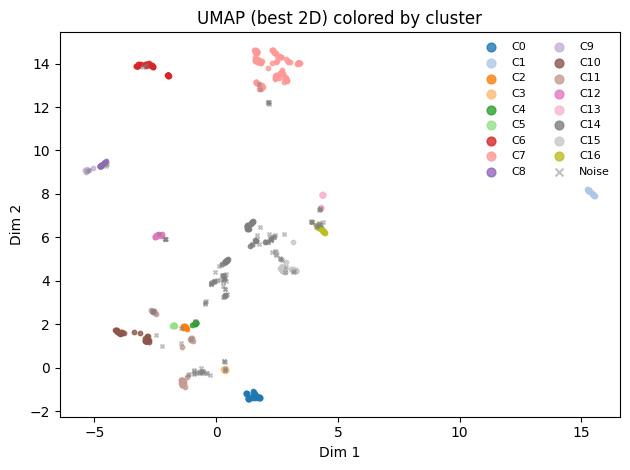

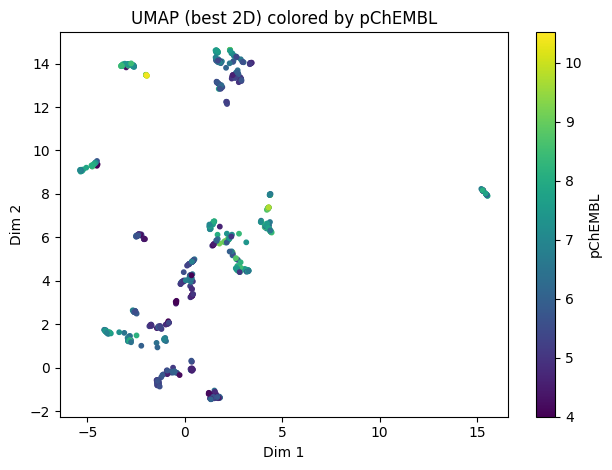

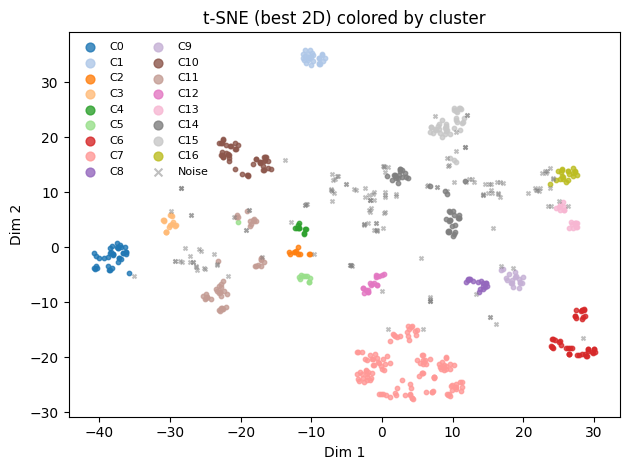

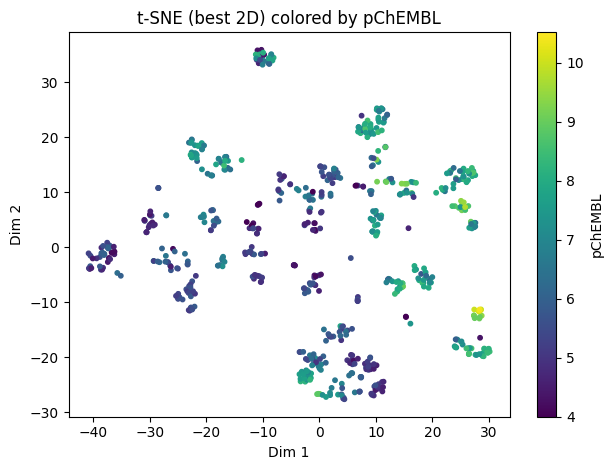

In [27]:
# ---- Visualization (Matplotlib only; one plot per figure; with distinct colors) ----
def scatter2d(X2, labels, title, fname):
    plt.figure()
    uniq = sorted(set(labels[labels>=0].tolist()))
    
    n_clusters = len(uniq)
    if n_clusters <= 10:
        colors = plt.cm.tab10(np.linspace(0, 1, 10))
    elif n_clusters <= 20:
        colors = plt.cm.tab20(np.linspace(0, 1, 20))
    else:
        colors = plt.cm.hsv(np.linspace(0, 0.9, n_clusters))
    
    for i, cid in enumerate(uniq):
        idx = (labels == cid)
        plt.scatter(X2[idx,0], X2[idx,1], s=10, label=f"C{cid}", 
                   alpha=0.8, color=colors[i])
    
    if np.any(labels < 0):
        idx = (labels < 0)
        plt.scatter(X2[idx,0], X2[idx,1], s=8, marker='x', 
                   alpha=0.5, color='gray', label='Noise')
    
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(markerscale=2, fontsize=8, ncol=2, frameon=False)
    plt.tight_layout()
    plt.savefig(Path(CFG.out_dir)/fname, dpi=200)
    plt.show()

def scatter2d_continuous(X2, values, title, fname):
    plt.figure()
    plt.scatter(X2[:,0], X2[:,1], s=10, c=values, cmap='viridis')
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.colorbar(label="pChEMBL")
    plt.tight_layout()
    plt.savefig(Path(CFG.out_dir)/fname, dpi=200)
    plt.show()

scatter2d(UMAP_2D, labels_best, "UMAP (best 2D) colored by cluster", "umap_clusters.png")
scatter2d_continuous(UMAP_2D, y_cont, "UMAP (best 2D) colored by pChEMBL", "umap_pchembl.png")
scatter2d(TSNE_2D, labels_best, "t-SNE (best 2D) colored by cluster", "tsne_clusters.png")
scatter2d_continuous(TSNE_2D, y_cont, "t-SNE (best 2D) colored by pChEMBL", "tsne_pchembl.png")

In [24]:
# ---- Top enriched clusters details ----
thr_focus = 7.0
et_best = enrichment_table(labels_best, (y_cont >= thr_focus).astype(int))
top_enriched = et_best[et_best['qvalue']<=0.05].head(5)
top_enriched

def medoid_of_cluster(D, labels, cluster_id):
    idx = np.where(labels==cluster_id)[0]
    if len(idx) == 0:
        return None
    sub = D[np.ix_(idx, idx)]
    medoid_local = np.argmin(sub.sum(axis=1))
    return idx[medoid_local]

def depict_molecules(indices, mols, legends, fname):
    ms = [mols[i] for i in indices]
    img = Draw.MolsToGridImage(ms, molsPerRow=5, subImgSize=(250,250), legends=legends, returnPNG=False)
    img.save(Path(CFG.out_dir)/fname)

# For each top cluster: medoid + 4 nearest neighbors
for cid in top_enriched['cluster_id'].tolist():
    med = medoid_of_cluster(D, labels_best, cid)
    if med is None:
        continue
    idx = np.where(labels_best==cid)[0]
    # Sort members by distance to medoid
    order = np.argsort(D[med, idx])
    top5 = idx[order[:5]]
    legends = [f"Idx {i}\npChEMBL {y_cont[i]:.2f}" for i in top5]
    depict_molecules(top5, sdf['mol'].tolist(), legends, f"cluster_{cid}_medoid_neighbors.png")

# Murcko scaffolds coverage
def murcko_smiles(m):
    try:
        scaf = MurckoScaffold.GetScaffoldForMol(m)
        return Chem.MolToSmiles(scaf, isomericSmiles=True)
    except Exception:
        return None

records = []
for cid in top_enriched['cluster_id'].tolist():
    idx = np.where(labels_best==cid)[0]
    sset = [murcko_smiles(sdf['mol'].iloc[i]) for i in idx]
    cnt = Counter([s for s in sset if s])
    if len(cnt):
        top_scaf, scaf_n = cnt.most_common(1)[0]
        records.append(dict(cluster_id=cid, top_scaffold=top_scaf, coverage=scaf_n/len(idx), size=len(idx)))
pd.DataFrame(records).sort_values('coverage', ascending=False)

,cluster_id,top_scaffold,coverage,size
1,16,c1ccc(N2CCCC2)c(CN2CCNCC2)c1,0.333333,21
4,8,O=C(c1nccs1)N1CCN(C2CC(=O)N(c3cccc(-c4ccccc4)c...,0.294118,17
0,6,O=C1NC2(CO1)CC(C(=O)N1CC(OCc3ccccc3)C1)C2,0.279070,43
2,15,O=C(N1CCN(Cc2ccccc2)CC1)n1nnc2ccccc21,0.236842,38
3,9,O=C(c1ccccc1)N1CCN(C2CN(C(=O)c3ccc4c(ccn4-c4cc...,0.166667,18


Permutations: 100%|██████████| 200/200 [00:00<00:00, 940.13it/s]


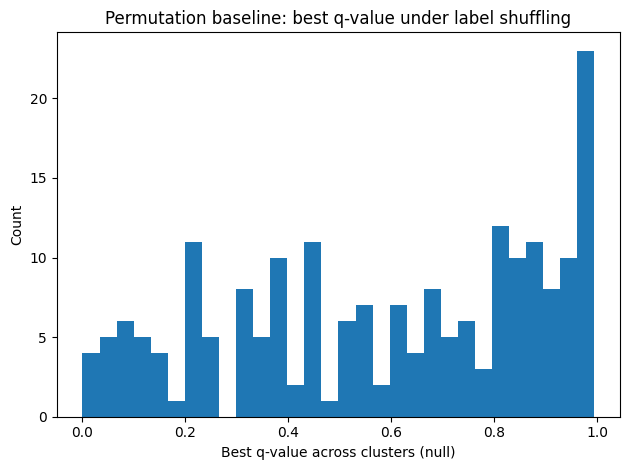

In [25]:
# ---- Permutation baseline for enrichment (activity labels) ----
pb = permutation_baseline(labels_best, (y_cont >= thr_focus).astype(int), iters=CFG.permutation_iters, seed=CFG.random_state)
if len(pb):
    plt.figure()
    plt.hist(pb['best_q'].values, bins=30)
    plt.xlabel("Best q-value across clusters (null)")
    plt.ylabel("Count")
    plt.title("Permutation baseline: best q-value under label shuffling")
    plt.tight_layout()
    plt.savefig(Path(CFG.out_dir)/"perm_best_q_hist.png", dpi=200)
    plt.show()
else:
    print("Permutation baseline returned empty (unexpected).")

In [26]:
for thr in CFG.thresholds:
    et = enrichment_table(labels_best, (y_cont >= thr).astype(int))
    sig = et[et['qvalue']<=0.05].copy()
    sig = sig.sort_values(['qvalue','OR','ratio'], ascending=[True, False, False])
    print(f"  Threshold pChEMBL ≥ {thr:.1f}: {len(sig)} enriched clusters at q≤0.05.")
    if len(sig):
        display(sig.head(5))

  Threshold pChEMBL ≥ 6.0: 8 enriched clusters at q≤0.05.


,cluster_id,n,actives,ratio,OR,pvalue,ci_low,ci_high,qvalue,significant
10,10,45,45,1.000000,75.052851,6.022757e-12,0.921346,1.000000,1.023869e-10,True
6,6,43,42,0.976744,23.096552,7.222473e-10,0.879407,0.995883,6.139102e-09,True
15,15,38,37,0.973684,20.102041,1.238888e-08,0.865048,0.995340,7.020368e-08,True
16,16,21,21,1.000000,33.245111,7.742187e-06,0.845356,1.000000,3.290429e-05,True
13,13,18,18,1.000000,28.384217,4.284743e-05,0.824115,1.000000,1.456813e-04,True


  Threshold pChEMBL ≥ 7.0: 7 enriched clusters at q≤0.05.


,cluster_id,n,actives,ratio,OR,pvalue,ci_low,ci_high,qvalue,significant
6,6,43,40,0.930233,24.946557,4.311084e-16,0.813907,0.975989,7.328843e-15,True
16,16,21,20,0.952381,27.004376,8.306428e-09,0.773302,0.991544,7.060463e-08,True
15,15,38,30,0.789474,7.299637,2.141977e-08,0.636539,0.889253,1.213787e-07,True
9,9,18,14,0.777778,6.162758,2.549140e-04,0.547850,0.909992,1.083385e-03,True
8,8,17,13,0.764706,5.713376,5.826426e-04,0.527378,0.904451,1.980985e-03,True


  Threshold pChEMBL ≥ 8.0: 3 enriched clusters at q≤0.05.


,cluster_id,n,actives,ratio,OR,pvalue,ci_low,ci_high,qvalue,significant
6,6,43,27,0.627907,12.858720,4.137657e-14,0.478595,0.756239,7.034018e-13,True
13,13,18,8,0.444444,5.041320,1.936103e-03,0.245592,0.662839,1.645687e-02,True
8,8,17,7,0.411765,4.401645,6.353792e-03,0.216108,0.639949,3.600482e-02,True
